# Проект "Модель для оценки водительского риска"

# Описание проекта

Задача: разработать модель, которая могла бы оценить вероятность ДТП с любым повреждением транспортного средства.

Данные: исторические данные одного из регионов, где собрана общая информация о ДТП и ее участниках.

Ход работы:

- загрузка таблиц SQL;
- первичное EDA;
- статистический анализ факторов ДТП;
- подготовка набора данных;
- отбор факторов (признаков), влияющих на вероятность ДТП;
- EDA,  замена аномальных значений и заполнение пропущенных значений. Создание новых признаков на основе существующих.
- корреляционный анализ;
- поиск удачной для модели конфигурации гиперпараметров;
- тестирование;
- построена "матрица ошибок".


# Шаг 1. Загрузка таблиц sql

In [1]:
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install sweetviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 4.2 MB/s eta 0:00:00


In [3]:
!pip install lightgbm -q

In [4]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.8 MB/s eta 0:00:00


In [5]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.2 MB/s eta 0:00:00


In [6]:
!pip install optuna-integration -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 945.4 kB/s eta 0:00:00


In [7]:
from sqlalchemy import create_engine

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sweetviz as sv

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

import optuna
from optuna import Trial
from optuna.trial import TrialState
import optuna.integration.lightgbm as lgb

import sklearn
from sklearn.metrics import (
                             f1_score,
                             precision_recall_curve,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             classification_report,
                             precision_score,
                             recall_score
                            )

from sklearn.linear_model import LogisticRegression as LR

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier, Pool

import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from optuna.terminator.callback import TerminatorCallback
from optuna.terminator.erroreval import report_cross_validation_scores
from lightgbm import LGBMClassifier


from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import make_column_transformer

import time
from sklearn.inspection import permutation_importance

In [9]:
import pickle

In [10]:
RANDOM_STATE = 12345

In [11]:
db_config = {
    ...
}

In [12]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

con = create_engine(connection_string)

# Шаг 2. Первичное исследование таблиц

## Сollisions (информация о происшествиях)

In [13]:
query = '''
SELECT *
FROM collisions
LIMIT 2
'''

table_collisions = pd.read_sql_query(query, con=con)
table_collisions

case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   

  primary_collision_factor pcf_violation_category type_of_collision  \
0   vehicle code violation     unsafe lane change         sideswipe   
1   vehicle code violation       improper passing        hit object   

  motor_vehicle_involved_with road_surface road_condition_1  \
0         other motor vehicle          wet           normal   
1                fixed object          dry           normal   

                  lighting control_device collision_date collision_time  
0                 daylight           none     2009-01-22       07:25:00  
1  dark with street lights    functioning     2009-01-03       02:26:00

## Parties (описание участников происшествия)

In [14]:
query_2 = '''
SELECT *
FROM Parties
LIMIT 2
'''

table_parties = pd.read_sql_query(query_2, con=con)
table_parties

id  case_id  party_number  party_type  at_fault  insurance_premium  \
0  22  3899454             1  road signs         1                 29   
1  23  3899454             2  road signs         0                  7   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None                 0  
1  had not been drinking                None                 0

In [15]:
t1_2 = table_parties.loc[(table_parties['case_id'] == '3899454')]
t1_2

id  case_id  party_number  party_type  at_fault  insurance_premium  \
0  22  3899454             1  road signs         1                 29   
1  23  3899454             2  road signs         0                  7   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None                 0  
1  had not been drinking                None                 0

## Vehicles (Описание автомобиля)

In [16]:
query_3 = '''
SELECT *
FROM Vehicles
LIMIT 2
'''

table_vehicles = pd.read_sql_query(query_3, con=con)
table_vehicles

id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   

   vehicle_age  
0            3  
1            3

In [17]:
t2 = table_vehicles.loc[(table_vehicles['id'] == 1)]
t2

id  case_id  party_number vehicle_type vehicle_transmission  vehicle_age
1   1  3858022             1        sedan                 auto            3

## case_ids (ключ)

In [18]:
query_4 = '''
SELECT *
FROM case_ids
LIMIT 2
'''

table_case_ids = pd.read_sql_query(query_4, con=con)
table_case_ids

case_id db_year
0  0081715    2021
1  0726202    2021

In [19]:
table_case_ids['db_year'].unique()

array(['2021'], dtype=object)

#  Шаг 3. Статистический анализ факторов ДТП

### Шаг 3.1. Анализ, в какие месяцы происходит наибольшее количество аварий.

In [20]:
query_step_3 = '''
SELECT COUNT(case_id),
       EXTRACT(MONTH FROM collision_date) AS month,
       EXTRACT(YEAR FROM collision_date) AS year
FROM collisions
GROUP BY collision_date;
'''

table_step_3 = pd.read_sql_query(query_step_3, con=con)
table_step_3

count  month    year
0      1001    1.0  2009.0
1      1072    1.0  2009.0
2       908    1.0  2009.0
3       699    1.0  2009.0
4      1084    1.0  2009.0
...     ...    ...     ...
1545      1    4.0  2013.0
1546      1    6.0  2013.0
1547      1    7.0  2013.0
1548      1    3.0  2020.0
1549      1    7.0  2020.0

[1550 rows x 3 columns]

In [21]:
table_step_3['month'] = table_step_3['month'].astype('int64')

In [22]:
table_step_3.dtypes

count      int64
month      int64
year     float64
dtype: object

In [23]:
table_step_3['year'] = table_step_3['year'].astype('int64')

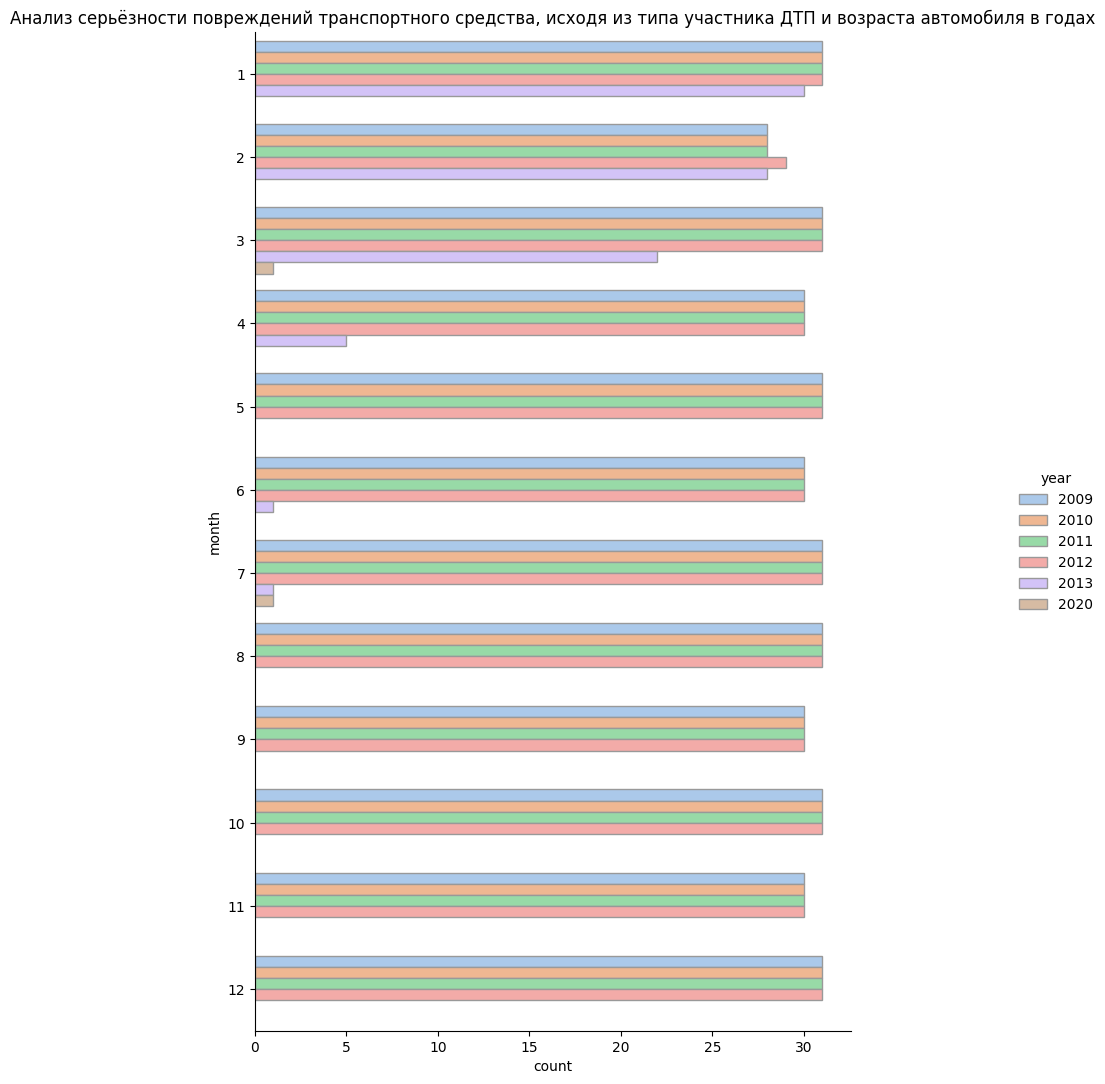

In [24]:
mon = sns.catplot(
    data=table_step_3, y='month', hue="year", kind="count",
    palette="pastel", edgecolor=".6",
)
mon.set(title='Анализ серьёзности повреждений транспортного средства, исходя из типа участника ДТП и возраста автомобиля в годах')
mon.fig.set_figwidth(8.27)
mon.fig.set_figheight(11.7);

**Шаг 3.1. Вывод.** Данные распределены неравномерно по годам - оценивая визуально можно наблюдать, что с 2009 по 2012 гг. ДТП наиболее часто происходят - в месяцах - январь, март, апрель, июль, август, октябрь, декабрь.


Если брать 2013 год - то в данных представлено 6 месяцев наблюдений. 2020 год представлен только месяцами март и июль. Полной информации по этим годам нет.

### Шаг 3.2. Создание аналитических задач.

#### Шаг 3.2.1. Задачи:

1. **Проведите анализ серьёзности повреждений транспортного средства (collision_damage/collisions), исходя из типа участника ДТП и возраста автомобиля в годах : car (Parties) / vehicle_age (Vehicles);**

2. **Проведите анализ серьёзности повреждений транспортного средства (collision_damage/collisions), исходя из наличия телефона в автомобиле (возможности разговаривать по громкой связи): (cellphone_in_use/ Parties);**

3. **Проведите анализ факторов освещения (lighting/collisions) и состояния дороги во время ДТП (road_surface/collisions) и типа участника происшествия ((party_type/car)/ Parties);**

4. **Проведите анализ серьёзности повреждений транспортного средства (collision_damage/collisions), исходя из (weather_1 / collisions) - погодных условий?**

5. **Где чаще всего происходят аварии, в каких локациях? (county_location/ collisions)**

6. **В какое чаще всего время происходят ДТП? (collision_time/collisions)**

7. **Кто чаще всего основной виновник ДТП?((at_fault/party_type) / Parties)**

8. **Проанализируйте связь основного фактора аварии (primary_coll_factor/collisions) и серьезность ДТП (collision_damage/collisions)?**

#### Шаг 3.2.2. Реализация решения двух из представленных задач.

**Задача №1** Проведите анализ серьёзности повреждений транспортного средства (collision_damage/collisions), исходя из типа участника ДТП и возраста автомобиля в годах : car (Parties) / vehicle_age (Vehicles).

In [25]:
query_step_3_2_1 = '''
SELECT col.case_id,
    col.collision_damage,
       veh.vehicle_age
FROM Parties AS pt JOIN Vehicles AS veh ON pt.case_id=veh.case_id AND pt.party_number=veh.party_number
               JOIN collisions AS col ON col.case_id=pt.case_id
WHERE pt.party_type LIKE 'car'
GROUP BY col.case_id, col.collision_damage, veh.vehicle_age;
'''

table_year = pd.read_sql_query(query_step_3_2_1, con=con)
table_year

case_id collision_damage  vehicle_age
0       3858022     small damage          3.0
1       3899450          scratch         11.0
2       3899453          scratch         10.0
3       3899457     small damage          0.0
4       3899457     small damage          9.0
...         ...              ...          ...
896947  5668337     small damage          6.0
896948  5668348     small damage          3.0
896949  5668349     small damage         12.0
896950  5668352     small damage          3.0
896951  5668356     small damage          7.0

[896952 rows x 3 columns]

In [26]:
table_year.dtypes

case_id              object
collision_damage     object
vehicle_age         float64
dtype: object

In [27]:
table_year.isna().sum()

case_id                 0
collision_damage        0
vehicle_age         22133
dtype: int64

In [28]:
table_year = table_year.dropna(subset=['vehicle_age'])
table_year = table_year.reset_index(drop=True)

In [29]:
table_year['vehicle_age'].unique()

array([  3.,  11.,  10.,   0.,   9.,   6.,   5.,   7.,   1.,   8.,   4.,
         2.,  12.,  13.,  14., 161.,  15.,  16.,  17.,  19.,  20.,  18.])

In [30]:
table_year.isna().sum()

case_id             0
collision_damage    0
vehicle_age         0
dtype: int64

In [31]:
table_year['vehicle_age'] = table_year['vehicle_age'].astype('int64')

In [32]:
table_year.loc[table_year['vehicle_age']==161, 'vehicle_age'] = table_year['vehicle_age'].median()

In [33]:
table_year.head()

case_id collision_damage  vehicle_age
0  3858022     small damage            3
1  3899450          scratch           11
2  3899453          scratch           10
3  3899457     small damage            0
4  3899457     small damage            9

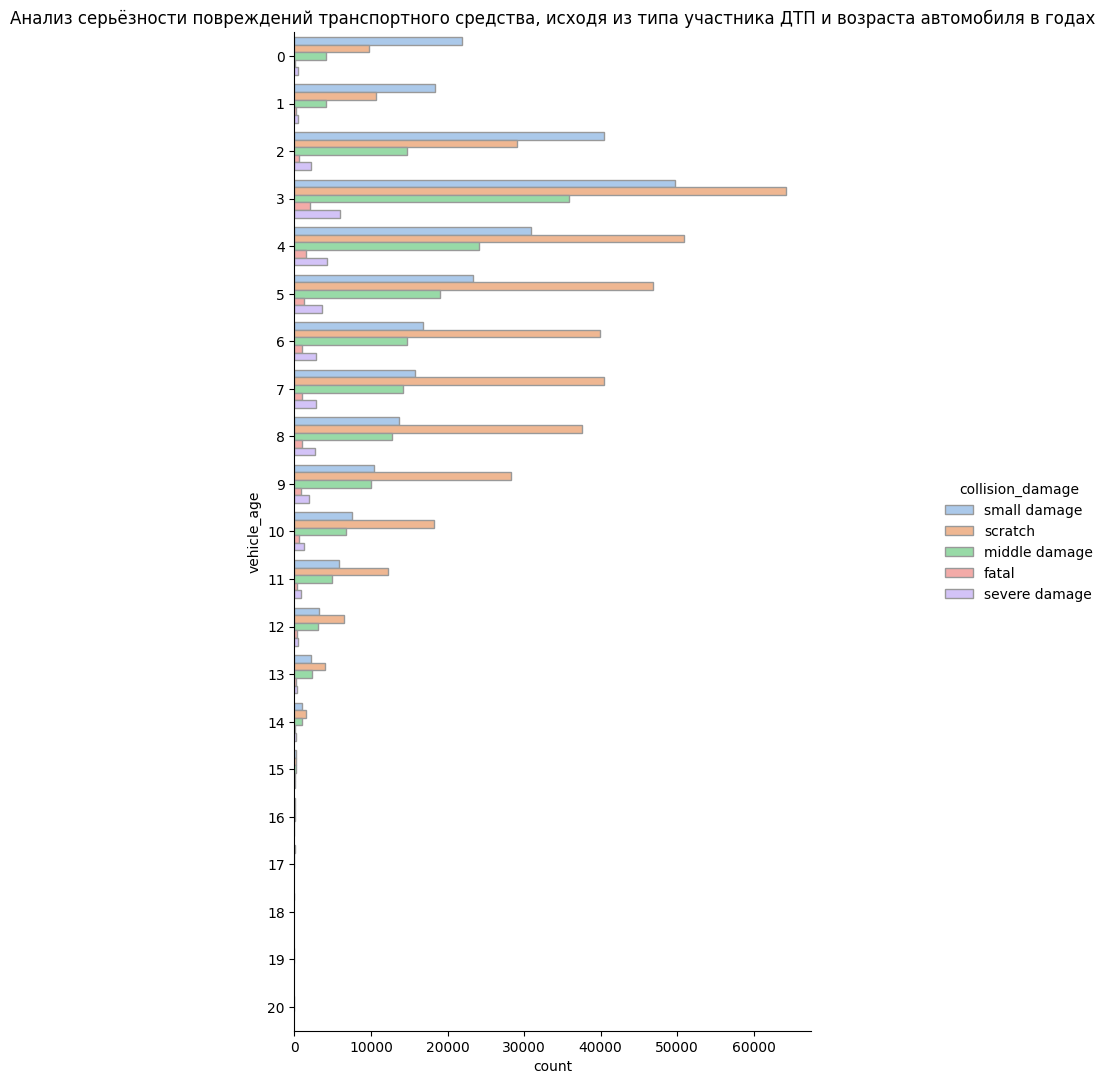

In [34]:
s = sns.catplot(
    data=table_year, y='vehicle_age', hue="collision_damage", kind="count",
    palette="pastel", edgecolor=".6",
)
s.set(title='Анализ серьёзности повреждений транспортного средства, исходя из типа участника ДТП и возраста автомобиля в годах')
s.fig.set_figwidth(8.27)
s.fig.set_figheight(11.7);

**Вывод:** В результате анализа серьёзности повреждений транспортного средства, исходя из типа участника ДТП (машина) и возраста автомобиля в годах, мы сделали вывод что к четвертому году пользования автомобилем возрастает количество происшествий с каждым типом исхода (серьёзности повреждений транспортного средства) : от царапины до состояния непригодности к ремонту. **Первые три года к большинству исходов случаев ДТП относятся небольшие повреждения (small damage) - когда отдельный элемент кузова идет под замену/покраску, а не к исходу в виде царапины, как в превалирующем числе случаев после 4 лет пользования автомобилем.**

**Задача №2:** Проведите анализ серьёзности повреждений транспортного средства (collision_damage/collisions), исходя из наличия телефона в автомобиле (возможности разговаривать по громкой связи): (cellphone_in_use/ Parties);

In [35]:
query_step_3_2_2 = '''
SELECT coll.case_id,
    coll.collision_damage,
       pt.cellphone_in_use
FROM case_ids AS c1 JOIN collisions AS coll ON c1.case_id=coll.case_id
                   JOIN Parties AS pt ON c1.case_id=pt.case_id
WHERE pt.party_type LIKE 'car'
GROUP BY coll.case_id, coll.collision_damage, pt.cellphone_in_use;
'''

table_cellphone = pd.read_sql_query(query_step_3_2_2, con=con)
table_cellphone

case_id collision_damage  cellphone_in_use
0        4644687          scratch               0.0
1        4535256     small damage               0.0
2        4673855          scratch               0.0
3        4580545     small damage               NaN
4        4273902     small damage               0.0
...          ...              ...               ...
1451366  4676375     small damage               NaN
1451367  4385586          scratch               0.0
1451368  5311970     small damage               0.0
1451369  5319632          scratch               0.0
1451370  5281435    middle damage               0.0

[1451371 rows x 3 columns]

In [36]:
table_cellphone['cellphone_in_use'].unique()

array([ 0., nan,  1.])

In [37]:
table_cellphone.isna().sum()

case_id                  0
collision_damage         0
cellphone_in_use    261465
dtype: int64

In [38]:
table_cellphone = table_cellphone.dropna(subset=['cellphone_in_use'])
table_cellphone = table_cellphone.reset_index(drop=True)

In [39]:
table_cellphone.isna().sum()

case_id             0
collision_damage    0
cellphone_in_use    0
dtype: int64

In [40]:
table_cellphone['cellphone_in_use'].unique()

array([0., 1.])

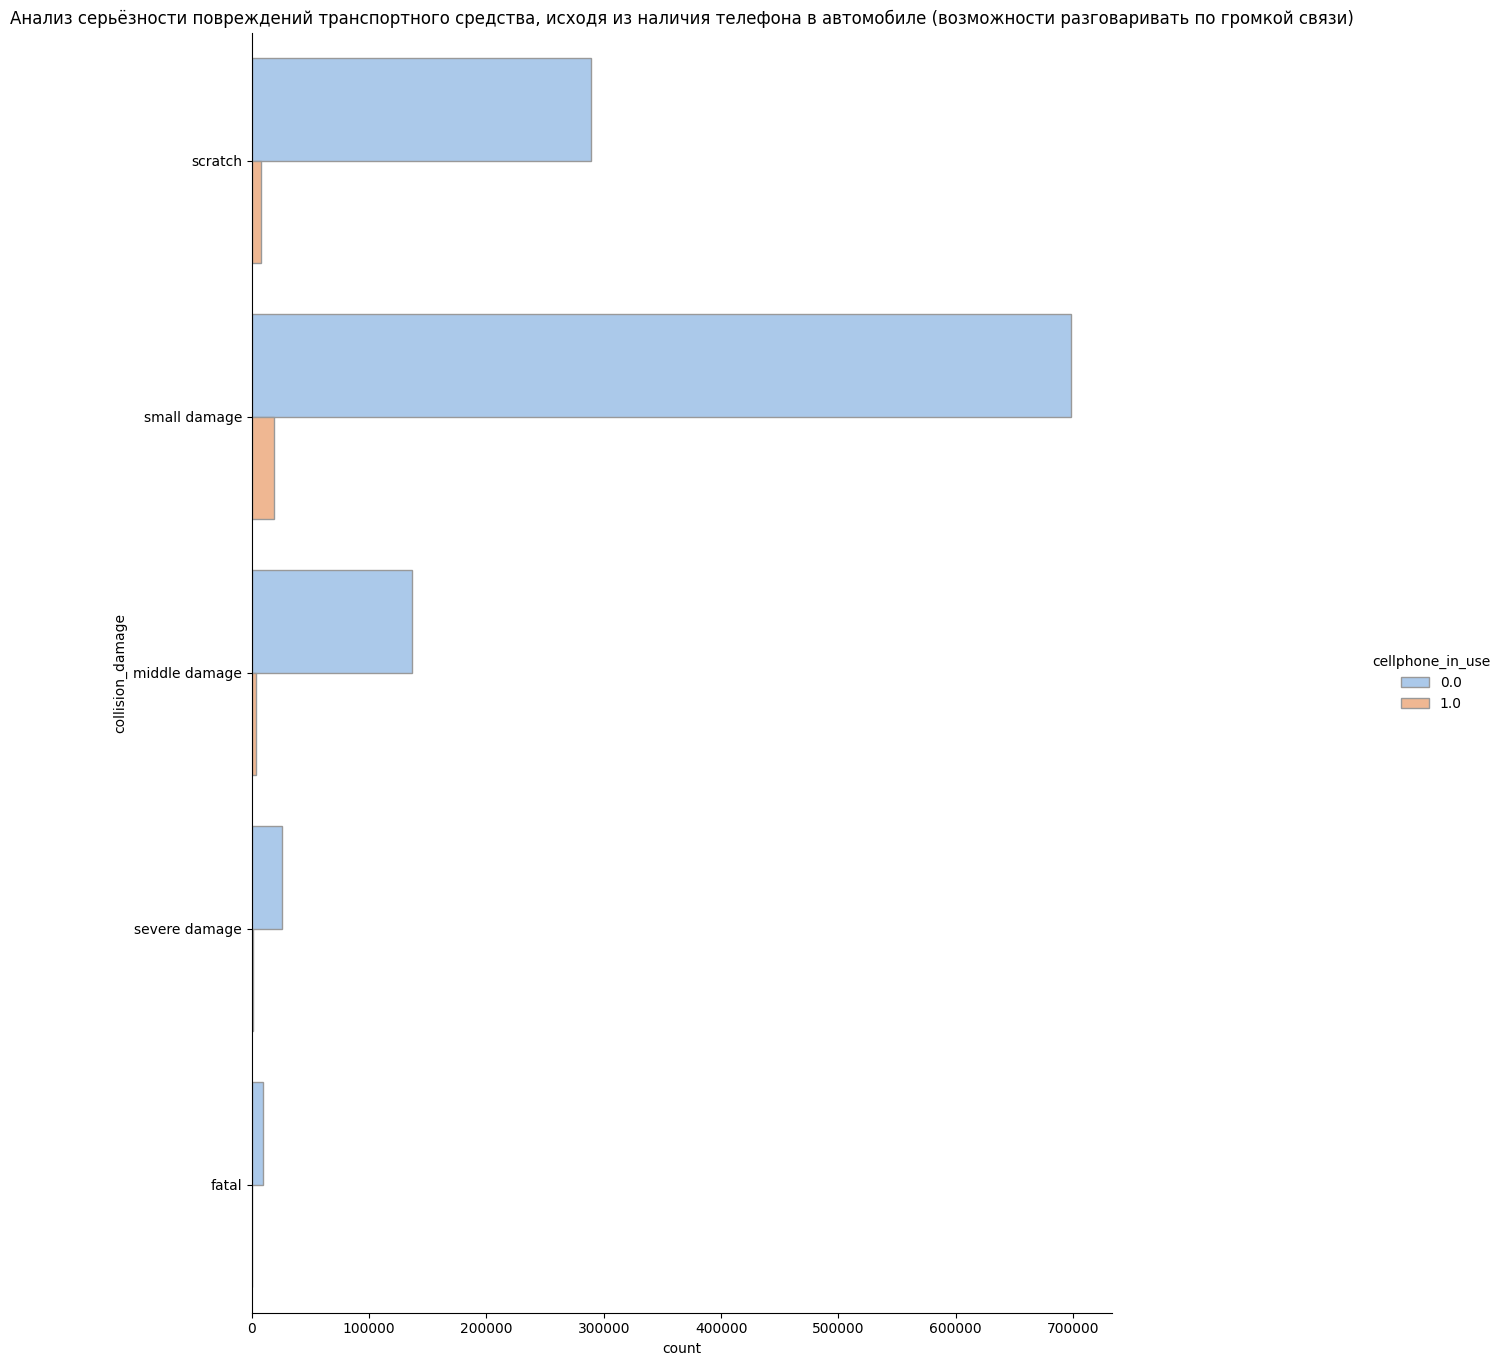

In [41]:
cellphone = sns.catplot(
    data=table_cellphone, y="collision_damage", hue='cellphone_in_use', kind="count",
    palette="pastel", edgecolor=".6",
)
cellphone.set(title='Анализ серьёзности повреждений транспортного средства, исходя из наличия телефона в автомобиле (возможности разговаривать по громкой связи)')
cellphone.fig.set_figwidth(18)
cellphone.fig.set_figheight(15);

**Вывод:** В результате анализа серьёзности повреждений транспортного средства, исходя из наличия телефона в автомобиле (возможности разговаривать по громкой связи), мы выявили следующие закономерности в представленных данных - что большинство случаев отсутствия громкой связи в автомобиле приходится на исходы в виде небольших повреждений (small damage) и царапин. Также можно выделить интересную закономерность - присутствовала громкая связь в салоне автомобиля и при исходах в виде небольших повреждений, требующих небольшого или среднего ремонта -   scratch , small damage, middle damage, но практически отсутствовала в случаях более серьезных.

# Шаг 4. Создание модели для оценки водительского риска

### Шаг 4.1. Подготовка набора данных с условиями:

In [42]:
query_step_4 = '''
WITH ab AS(SELECT *
           FROM Parties AS pt
           WHERE pt.party_type  = 'car'),
     ac AS (SELECT *
            FROM collisions AS coll
            WHERE CAST(coll.collision_date AS date) BETWEEN '2012-01-01' AND '2012-12-31'
            AND coll.collision_damage != 'scratch')
SELECT *
FROM ab JOIN Vehicles AS veh ON ab.case_id=veh.case_id AND ab.party_number=veh.party_number
               JOIN ac ON ac.case_id=ab.case_id;
'''


data_model = pd.read_sql_query(query_step_4, con=con)
data_model

id  case_id  party_number party_type  at_fault  insurance_premium  \
0      2429919  5467440             1        car         1               19.0   
1      2430968  5468008             2        car         1               22.0   
2      2432043  5468555             2        car         0               49.0   
3      2457737  5482494             2        car         0               21.0   
4      2458117  5482696             2        car         0               87.0   
...        ...      ...           ...        ...       ...                ...   
56243  2408927  5456188             3        car         0               83.0   
56244  2408972  5456210             1        car         0               47.0   
56245  2408995  5456221             2        car         0               19.0   
56246  2409355  5456411             2        car         0               62.0   
56247  2409517  5456492             2        car         0               20.0   

              party_sobriety party_drug_physical  cellphone_in_use       id  \
0      had not been drinking                None               0.0  1339067   
1      had not been drinking                None               0.0  1339600   
2      had not been drinking                None               NaN  1340172   
3      had not been drinking                None               0.0  1354464   
4      had not been drinking                None               0.0  1354639   
...                      ...                 ...               ...      ...   
56243  had not been drinking                None               1.0  1327835   
56244  had not been drinking                None               0.0  1327862   
56245  had not been drinking                None               0.0  1327875   
56246  had not been drinking                None               0.0  1328054   
56247  had not been drinking                None               0.0  1328119   

       ... primary_collision_factor     pcf_violation_category  \
0      ...   vehicle code violation           improper turning   
1      ...   vehicle code violation                   speeding   
2      ...   vehicle code violation  traffic signals and signs   
3      ...   vehicle code violation                   speeding   
4      ...   vehicle code violation           improper turning   
...    ...                      ...                        ...   
56243  ...   vehicle code violation           improper turning   
56244  ...   vehicle code violation    automobile right of way   
56245  ...   vehicle code violation         wrong side of road   
56246  ...   vehicle code violation                   speeding   
56247  ...   vehicle code violation    automobile right of way   

      type_of_collision motor_vehicle_involved_with  road_surface  \
0            hit object                fixed object           dry   
1            hit object                fixed object           dry   
2             broadside         other motor vehicle           dry   
3              rear end         other motor vehicle           dry   
4             sideswipe         other motor vehicle           dry   
...                 ...                         ...           ...   
56243         sideswipe         other motor vehicle           dry   
56244         broadside         other motor vehicle           dry   
56245             other                     bicycle           dry   
56246          rear end         other motor vehicle           dry   
56247         broadside         other motor vehicle           dry   

      road_condition_1                    lighting control_device  \
0               normal  dark with no street lights           none   
1               normal                    daylight    functioning   
2               normal                    daylight    functioning   
3               normal     dark with street lights           none   
4               normal                    daylight           none   
...                ...                         ...    

In [43]:
data_model.to_csv('final_data.csv', index=False)

In [44]:
data = pd.read_csv('final_data.csv')

### Шаг 4.2. Первичный отбор факторов, необходимых для модели.
- Нужно было изучить описание факторов и отобрать те, которые могут влиять на вероятность ДТП.

In [45]:
data.columns.values.tolist()

['id',
 'case_id',
 'party_number',
 'party_type',
 'at_fault',
 'insurance_premium',
 'party_sobriety',
 'party_drug_physical',
 'cellphone_in_use',
 'id.1',
 'case_id.1',
 'party_number.1',
 'vehicle_type',
 'vehicle_transmission',
 'vehicle_age',
 'case_id.2',
 'county_city_location',
 'county_location',
 'distance',
 'direction',
 'intersection',
 'weather_1',
 'location_type',
 'collision_damage',
 'party_count',
 'primary_collision_factor',
 'pcf_violation_category',
 'type_of_collision',
 'motor_vehicle_involved_with',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'collision_date',
 'collision_time']

In [46]:
cols =['county_city_location', #мы решили оставить оба признака, связанных с географическим положением, потому что
          'county_location', # впереди корреляционный анализ, на котором мы сможем выяснить какой признак лучше для обучения
           'distance', #Расстояние от главной дороги, может повлиять на вероятность ДТП
          'direction', #Южное направление может быть более сложным чем северное, в зависимости от качества дорожного полотна (к примеру)
          'weather_1', #Погода может явиться существенным фактором в случае ДТП. Туман, снегопад, дождь - могут явиться причиной аварии.
          'location_type', #Тип дороги - важный признак, который может повлиять на вероятность ДТП.
          'road_surface',#Состояние дороги - очень важный фактор, учитывая его возможно предугадать вероятность ДТП, но,
          #конечно, в связке с другими признаками.
          'road_condition_1',# Дорожное состояние - еще один важный фактор, учитывая который возможно предугадать вероятность ДТП
          #(в связке с другими факторами).
          'lighting',#Освещение - этот фактор мы тоже оставляем, вкупе с выделенным из времени номером часа,
          #это даст наиболее ясную картину. Освещение может влиять на вероятность случаев ДТП в данной географической точке.
          'control_device',#Мы решили изучить данный признак, но его конкретное назначение так и не поняли, он был удален впоследствии.
          'collision_date', #был выделен месяц, впоследствии признак будет удален.
          'collision_time', #был выделен час, впоследствии признак будет удален.
          'vehicle_type',# Тип кузова - мы решил оставить этот признак и посмотреть на корреляционную матрицу,
           #а впоследствии, решить - удалять его или нет. Мы думаем, что состояние автомобиля, в том числе тип его кузова могут
          #повлиять на вероятность ДТП (опять же в сумме с другими факторами).
          'vehicle_transmission',#Тип КПП - это более важный фактор, чем предыдущий,
           #мы думаем, что он может влиять на вероятность ДТП(в сумме с другими факторами).
          'vehicle_age',#Важный признак, тем более это обязательное условие заказчика — учесть фактор возраста автомобиля.
          'cellphone_in_use' #На наш взгляд, важный признак, влияющий на вероятность ДТП. Выше мы рассмотрели его связь
          #с фактором серьёзности повреждений транспортного средства (collision_damage/collisions).
          'intersection', # Заполнены пропуски в 'location_type' - этот признак позволил это сделать.
          'insurance_premium' #Размер страховки - мы до последнего не учитывали этот фактор,
          #но в итоге решили взять - и оказалось, что это самый важный признак для модели с наибольшей метрикой.
         ]

In [47]:
len(cols)

17

In [48]:
data.head()

id  case_id  party_number party_type  at_fault  insurance_premium  \
0  2429919  5467440             1        car         1               19.0   
1  2430968  5468008             2        car         1               22.0   
2  2432043  5468555             2        car         0               49.0   
3  2457737  5482494             2        car         0               21.0   
4  2458117  5482696             2        car         0               87.0   

          party_sobriety party_drug_physical  cellphone_in_use     id.1  ...  \
0  had not been drinking                 NaN               0.0  1339067  ...   
1  had not been drinking                 NaN               0.0  1339600  ...   
2  had not been drinking                 NaN               NaN  1340172  ...   
3  had not been drinking                 NaN               0.0  1354464  ...   
4  had not been drinking                 NaN               0.0  1354639  ...   

   primary_collision_factor     pcf_violation_category type_of_collision  \
0    vehicle code violation           improper turning        hit object   
1    vehicle code violation                   speeding        hit object   
2    vehicle code violation  traffic signals and signs         broadside   
3    vehicle code violation                   speeding          rear end   
4    vehicle code violation           improper turning         sideswipe   

  motor_vehicle_involved_with  road_surface  road_condition_1  \
0                fixed object           dry            normal   
1                fixed object           dry            normal   
2         other motor vehicle           dry            normal   
3         other motor vehicle           dry            normal   
4         other motor vehicle           dry            normal   

                     lighting control_device  collision_date collision_time  
0  dark with no street lights           none      2012-01-03       17:35:00  
1                    daylight    functioning      2012-01-02       15:00:00  
2                    daylight    functioning      2012-01-04       07:25:00  
3     dark with street lights           none      2012-01-20       17:25:00  
4                    daylight           none      2012-01-26       12:30:00  

[5 rows x 35 columns]

### Шаг 4.3.Статистическое исследование отобранных факторов.

In [49]:
features_null1 = ['case_id', 'case_id.1', 'party_number', 'id.1', 'party_count',
                 'id', 'party_type', 'party_drug_physical', 'party_sobriety', 'party_number.1', 'case_id.2',
                 'motor_vehicle_involved_with', 'collision_damage',  'primary_collision_factor',
                 'pcf_violation_category', 'type_of_collision']

In [50]:
data.drop(columns = features_null1, inplace=True)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              56248 non-null  int64  
 1   insurance_premium     55701 non-null  float64
 2   cellphone_in_use      51777 non-null  float64
 3   vehicle_type          56248 non-null  object 
 4   vehicle_transmission  55389 non-null  object 
 5   vehicle_age           54554 non-null  float64
 6   county_city_location  56248 non-null  int64  
 7   county_location       56248 non-null  object 
 8   distance              56248 non-null  float64
 9   direction             43230 non-null  object 
 10  intersection          56073 non-null  float64
 11  weather_1             56080 non-null  object 
 12  location_type         25932 non-null  object 
 13  road_surface          55900 non-null  object 
 14  road_condition_1      55999 non-null  object 
 15  lighting           

### Шаг 4.4. EDA,  замена аномальных значений и заполнение пропущенных значений. Создание новых признаков на основе существующих.

На основе анализа профайлера мы провели предобработку данных - в каких-то признаках произведена замена на медиану, в каких-то пропущенные значения заменены на **'other'** и **'unknown'**, либо для них создана отдельная категория **'unknown название признака'**. Также заменены аномальные значения на медианы в признаках - `distance` и `vehicle_age`.

                                             |          | [  0%]   00:00 -> (? left)


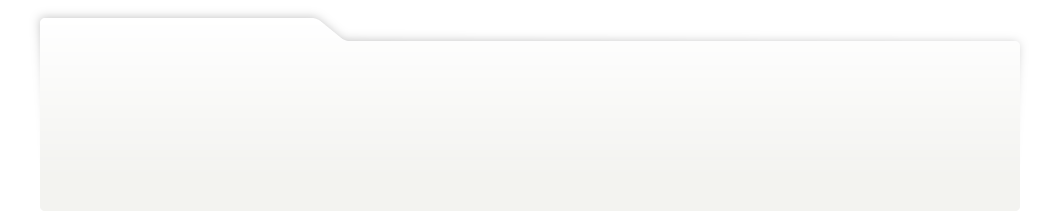
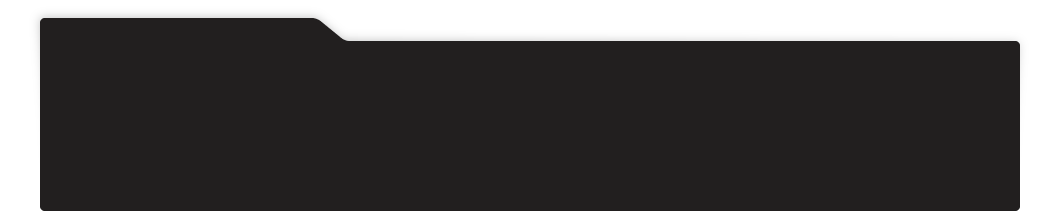
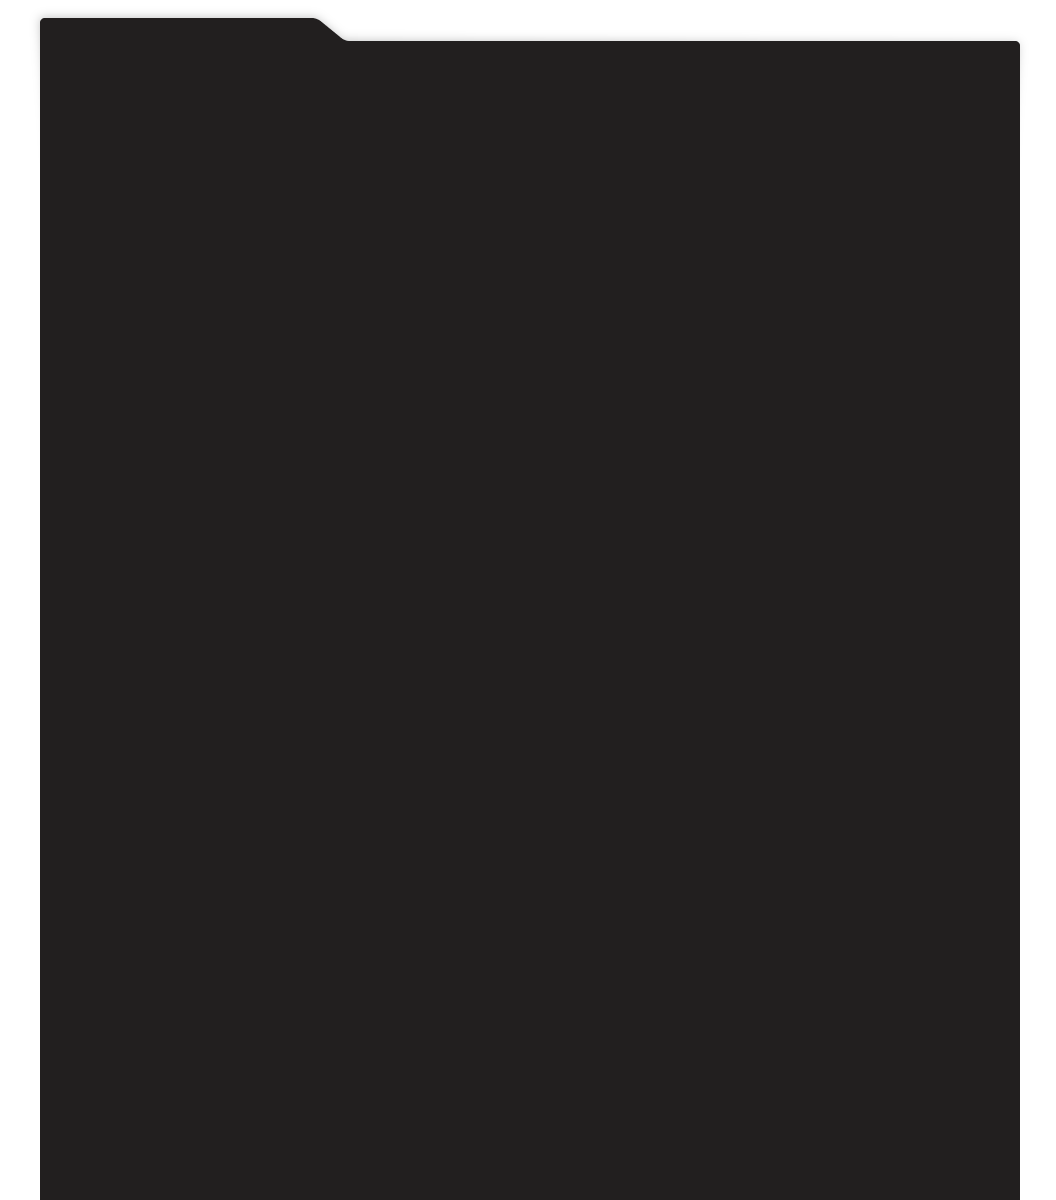
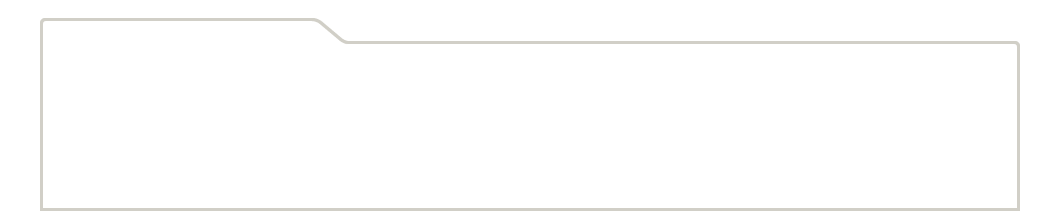
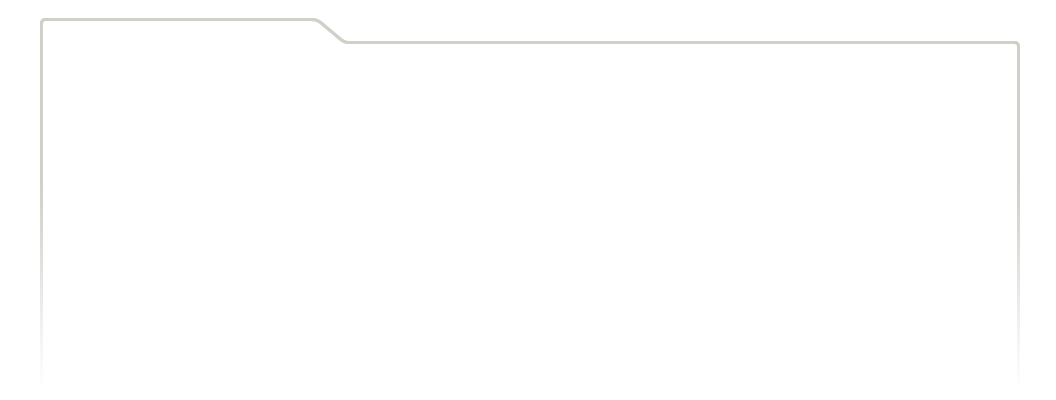
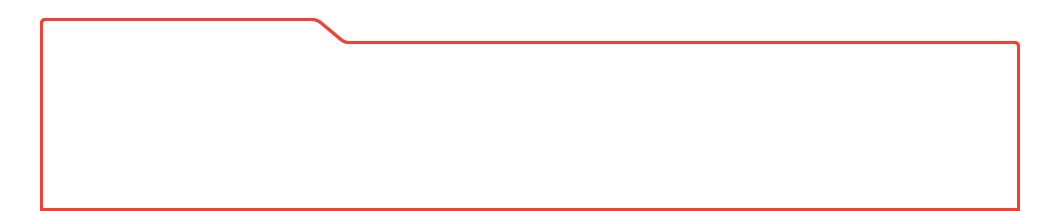
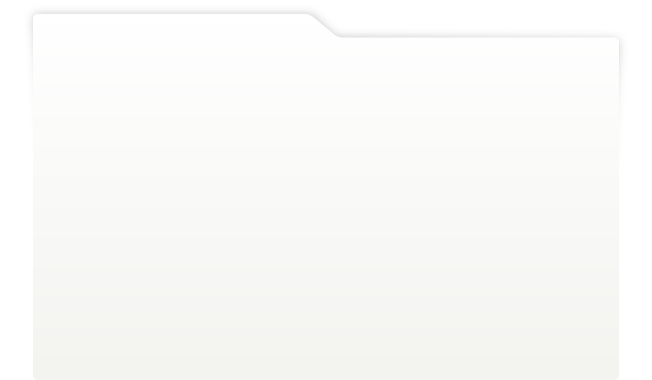
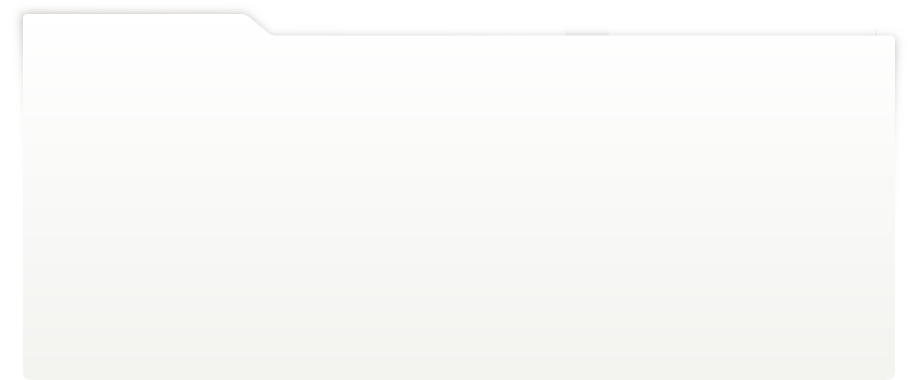
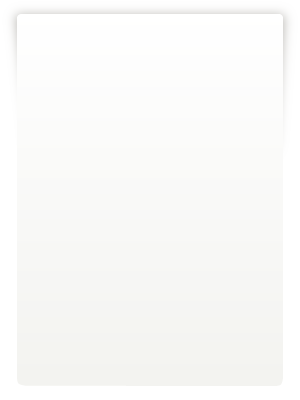
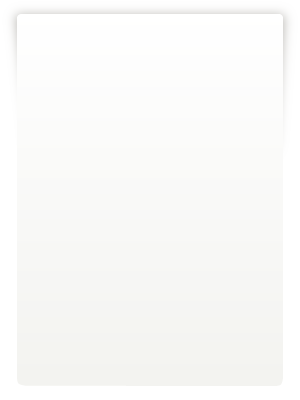
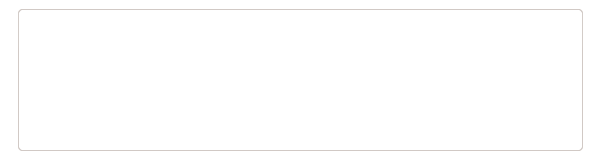
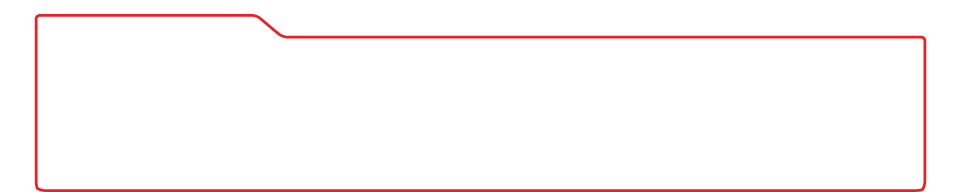
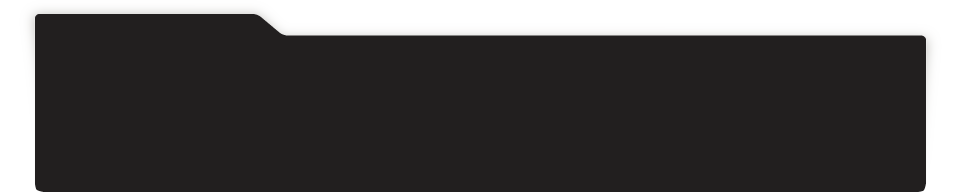
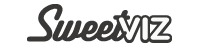
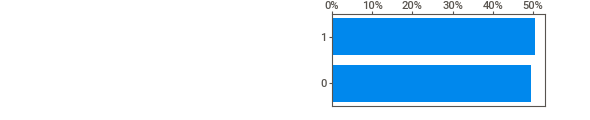
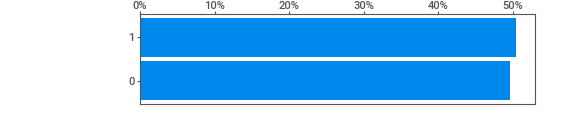
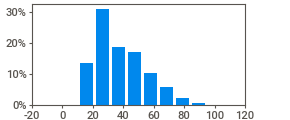
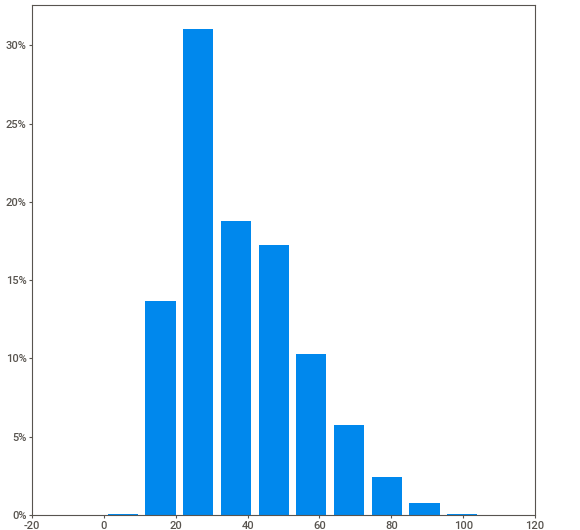
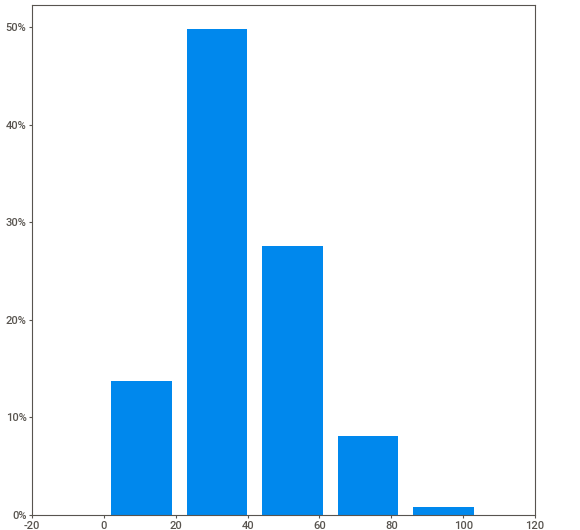
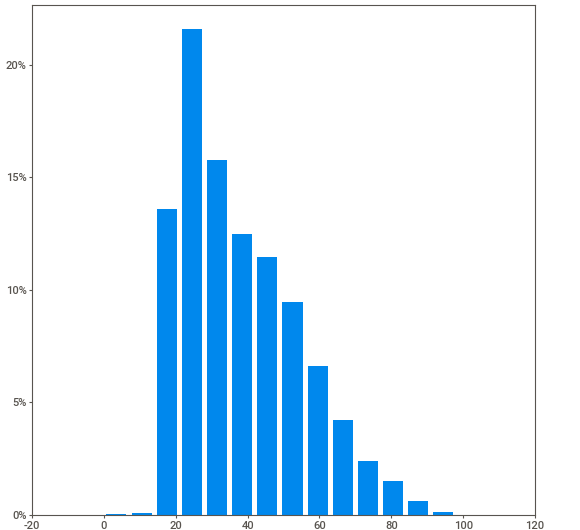
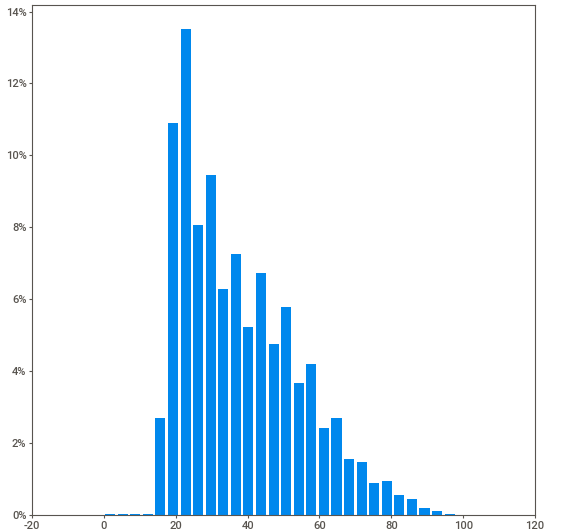
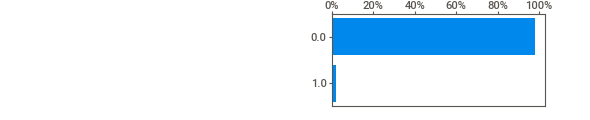
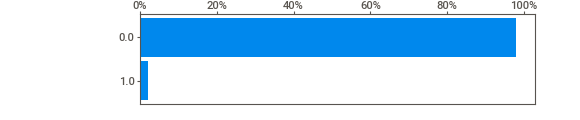
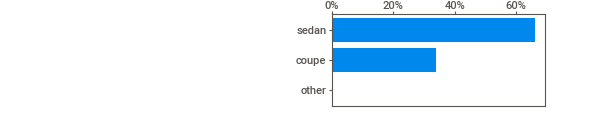
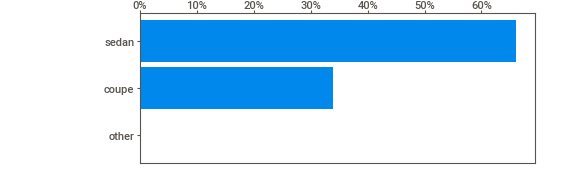
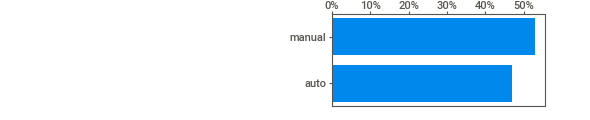
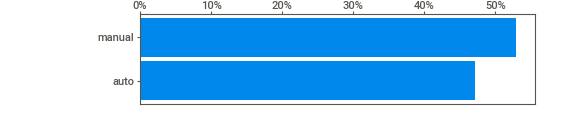
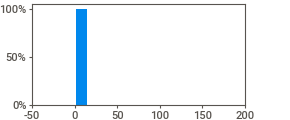
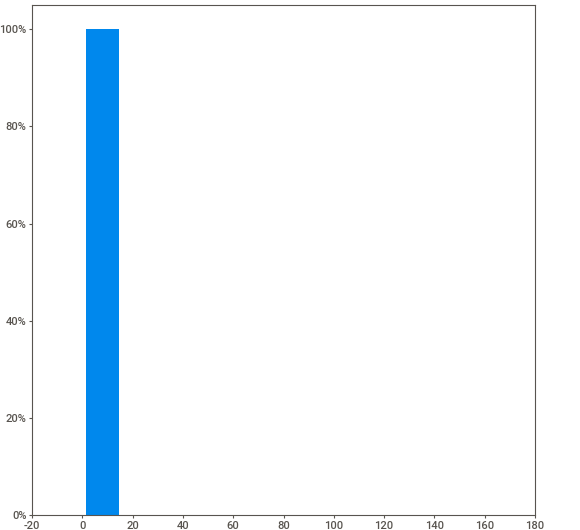
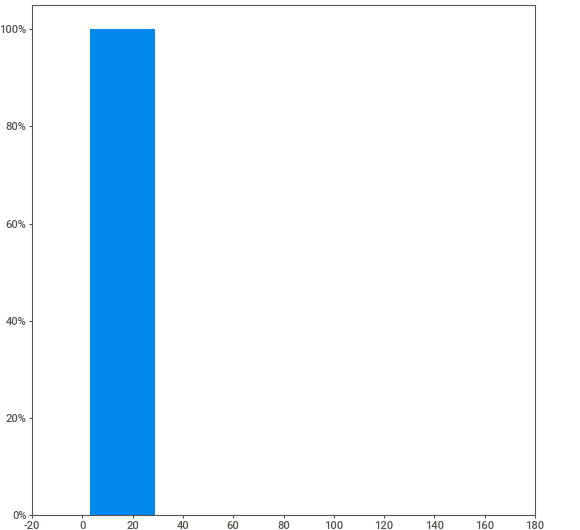
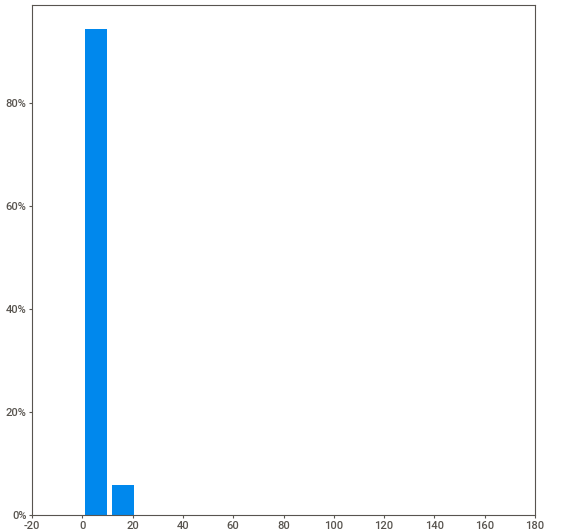
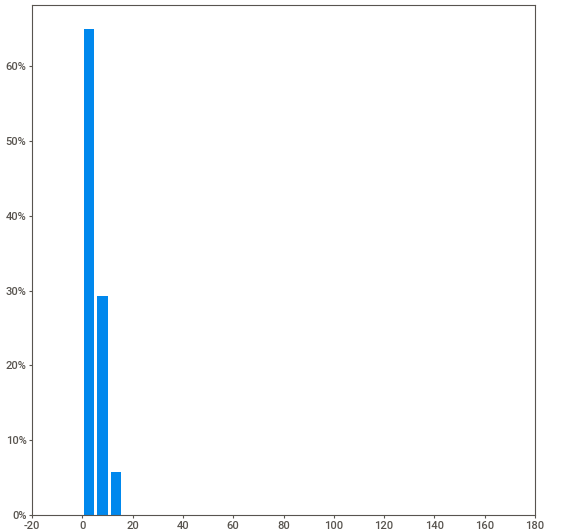
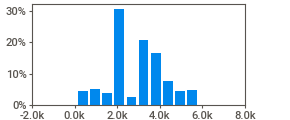
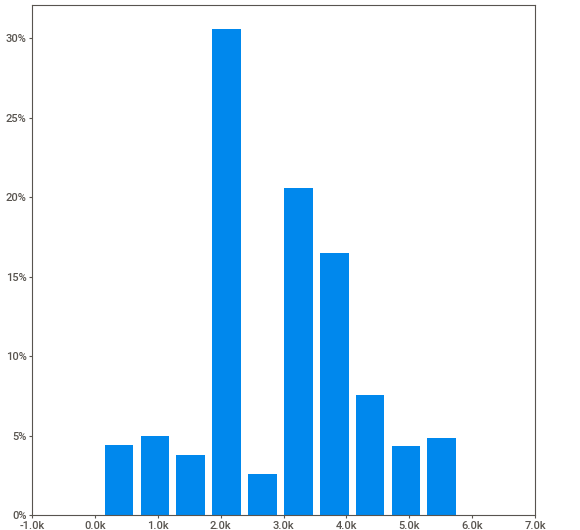
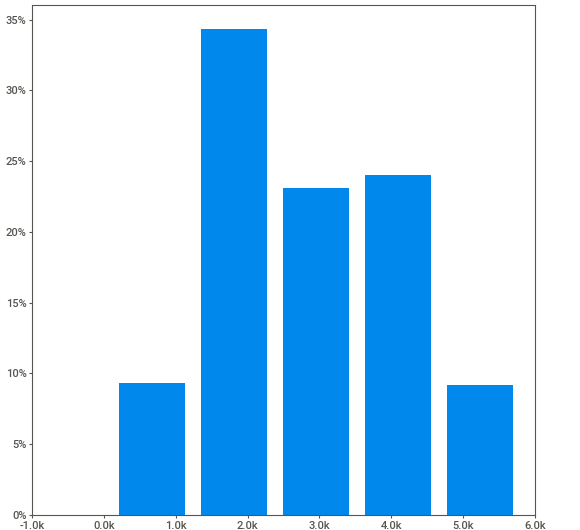
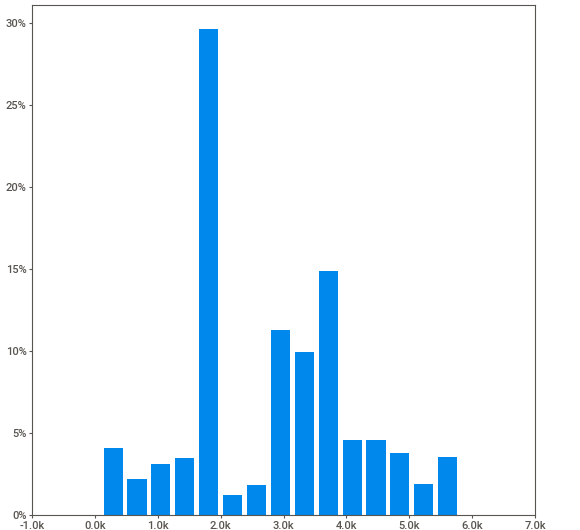
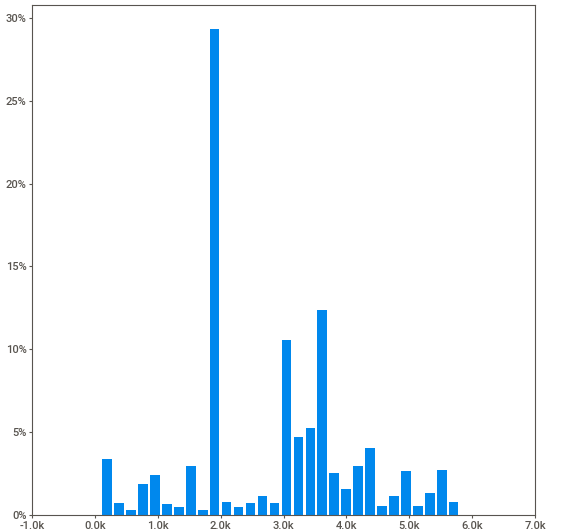
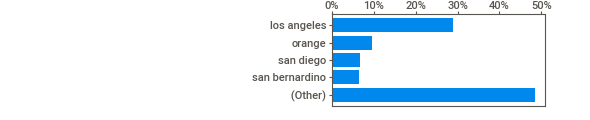
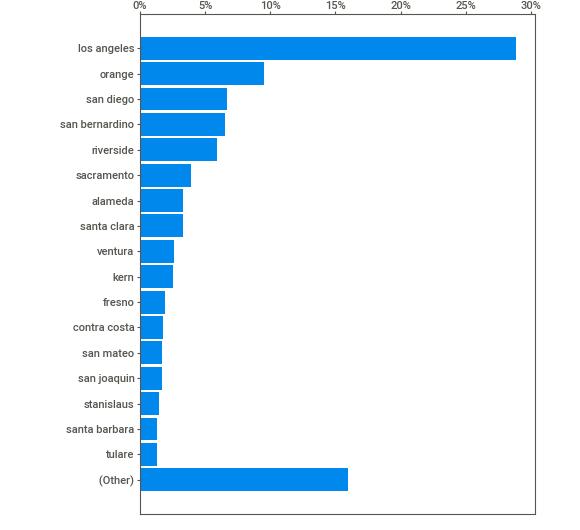
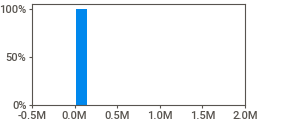
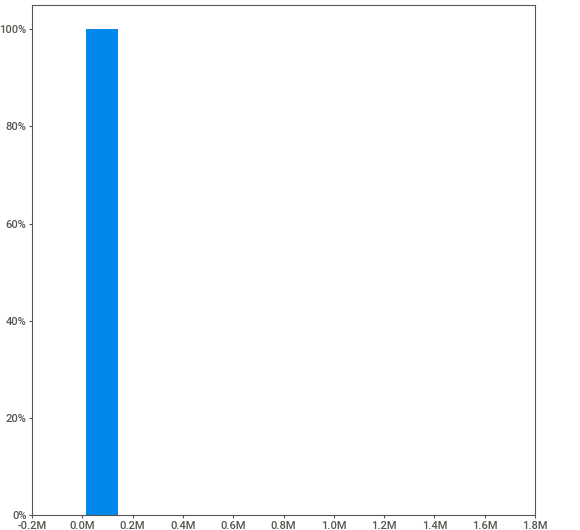
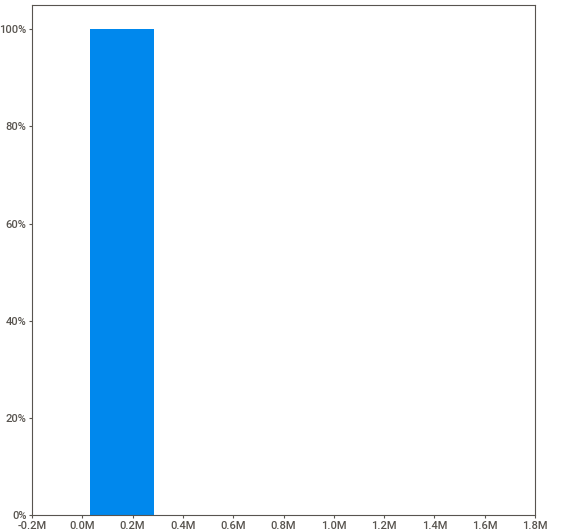
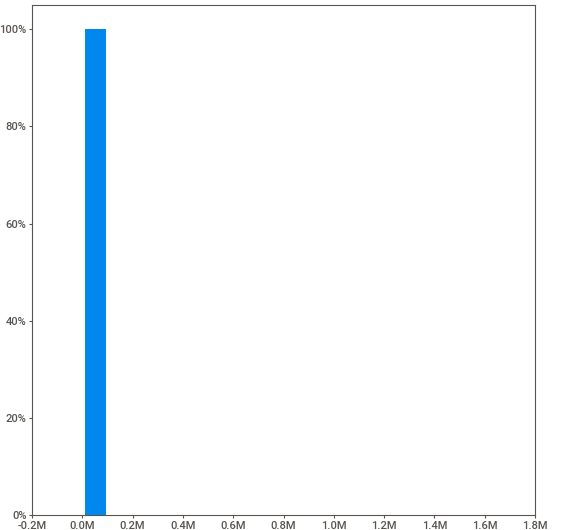
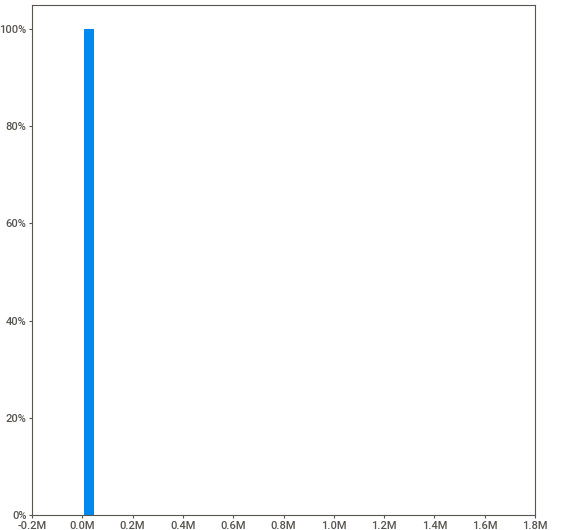
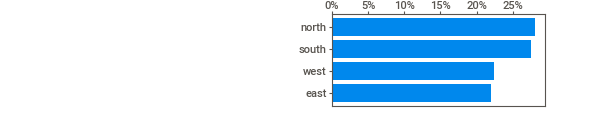
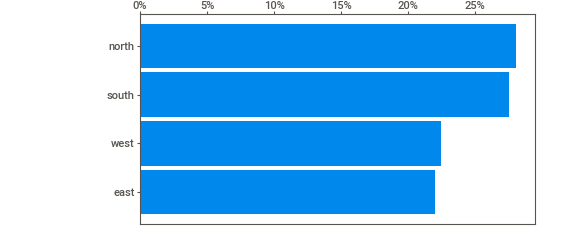
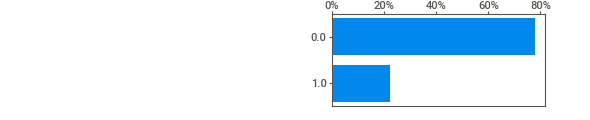
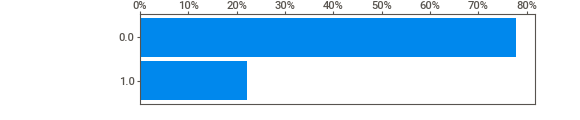
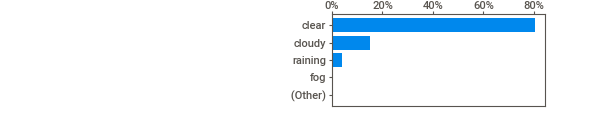
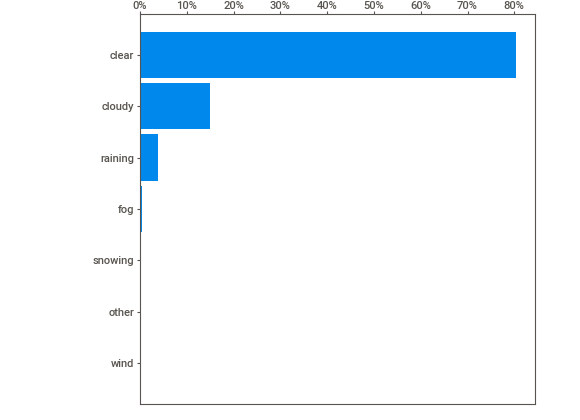
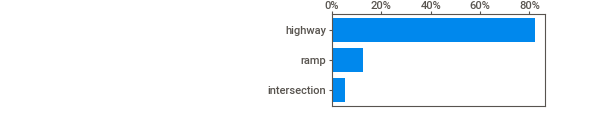
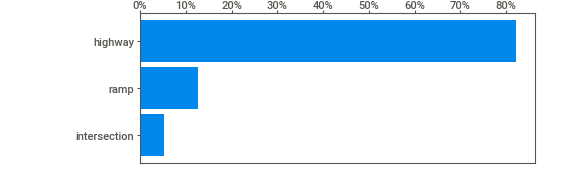
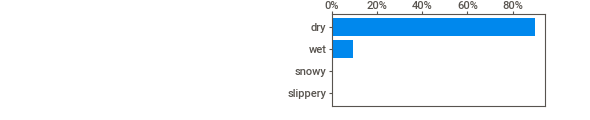
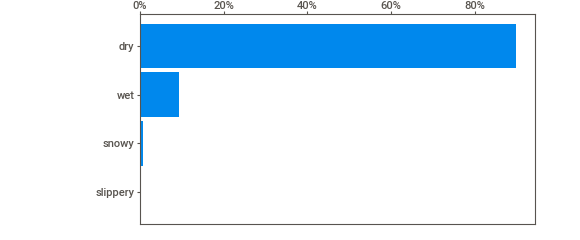
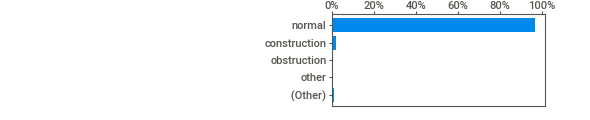
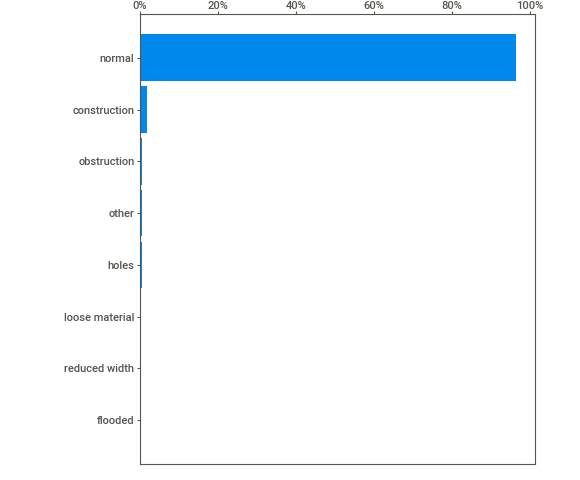
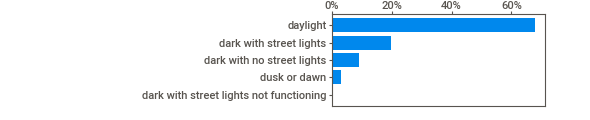
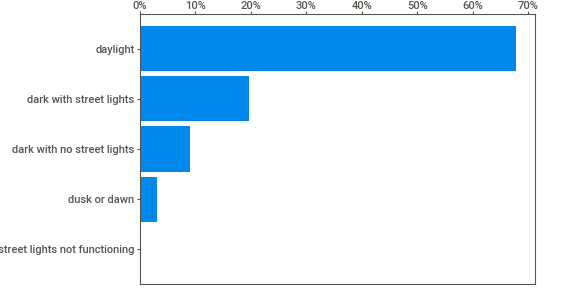
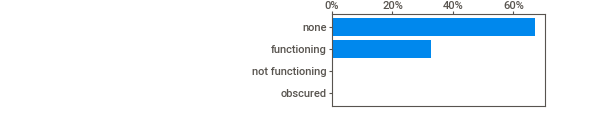
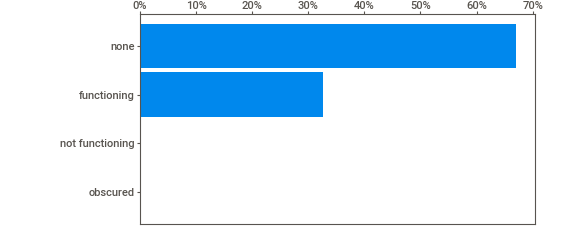
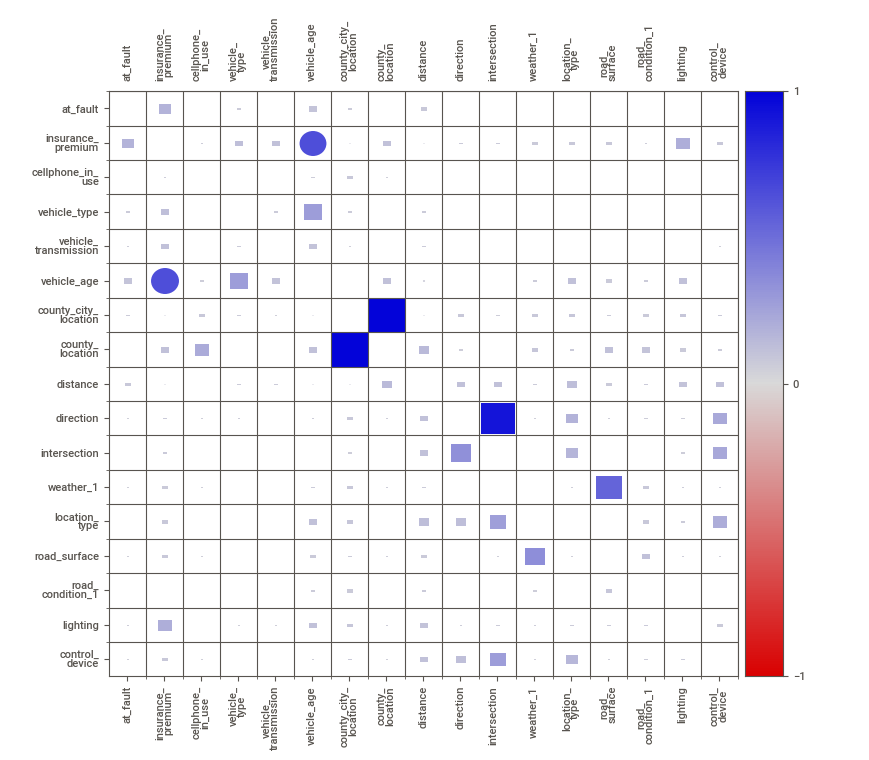
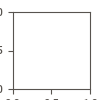

In [52]:
table_report = sv.analyze(data)
table_report.show_notebook()

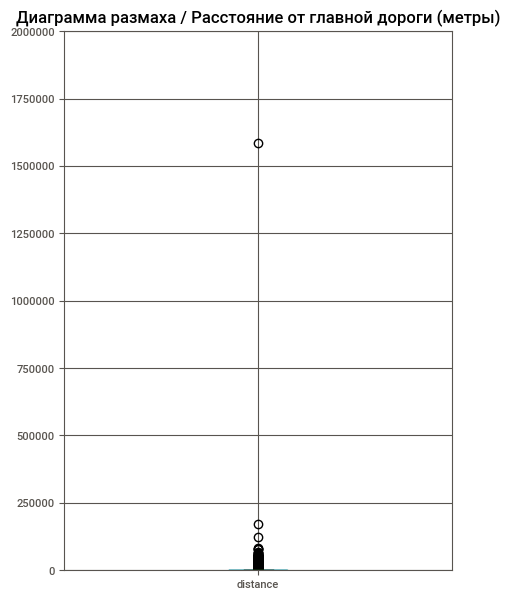

In [53]:
data.boxplot(column='distance', figsize=(5,7))
plt.ylim(-200, 2000000)
plt.title('Диаграмма размаха / Расстояние от главной дороги (метры)')
plt.show()

In [54]:
data.loc[(data['distance'] == 1584000)].T

23150
at_fault                        1
insurance_premium            22.0
cellphone_in_use              0.0
vehicle_type                sedan
vehicle_transmission       manual
vehicle_age                   3.0
county_city_location         1942
county_location       los angeles
distance                1584000.0
direction                   north
intersection                  0.0
weather_1                   clear
location_type             highway
road_surface                  dry
road_condition_1           normal
lighting                 daylight
control_device               none
collision_date         2012-05-22
collision_time           15:45:00

In [55]:
data['county_location'].unique()

array(['fresno', 'los angeles', 'orange', 'san diego', 'san joaquin',
       'san bernardino', 'monterey', 'kern', 'humboldt', 'santa clara',
       'sacramento', 'solano', 'riverside', 'merced', 'ventura',
       'stanislaus', 'alameda', 'tuolumne', 'san mateo', 'shasta',
       'butte', 'placer', 'mendocino', 'el dorado', 'yuba', 'colusa',
       'marin', 'san francisco', 'tulare', 'lake', 'madera', 'sonoma',
       'santa cruz', 'yolo', 'kings', 'san luis obispo', 'santa barbara',
       'contra costa', 'sutter', 'siskiyou', 'plumas', 'glenn',
       'imperial', 'inyo', 'san benito', 'tehama', 'trinity', 'napa',
       'mariposa', 'calaveras', 'nevada', 'alpine', 'amador', 'mono',
       'modoc', 'del norte', 'sierra', 'lassen'], dtype=object)

In [56]:
table_la = data.loc[(data['county_location'] == 'los angeles')]

In [57]:
la_dist = table_la.groupby(['county_city_location']).agg({'distance':'max'})

In [58]:
la_dist.sort_values('distance', ascending=False).head()

distance
county_city_location           
1942                  1584000.0
1900                    42240.0
1995                    17582.0
1926                    10560.0
1989                     7920.0

In [59]:
la_dist['distance'].median()

1675.0

In [60]:
data.isna().sum()

at_fault                    0
insurance_premium         547
cellphone_in_use         4471
vehicle_type                0
vehicle_transmission      859
vehicle_age              1694
county_city_location        0
county_location             0
distance                    0
direction               13018
intersection              175
weather_1                 168
location_type           30316
road_surface              348
road_condition_1          249
lighting                  154
control_device            215
collision_date              0
collision_time             88
dtype: int64

**Insurance_premium**

In [61]:
data['insurance_premium'] = data['insurance_premium'].fillna(data['insurance_premium'].median())

**Distance** --- замена аномального значения на медиану

In [62]:
data.loc[data['distance'] >= 1484000, 'distance'] = data['distance'].median()

**Direction**

In [63]:
data['direction'] = data['direction'].fillna('unknown_direction')

**Weather**

In [64]:
data['weather_1'].unique()

array(['clear', 'cloudy', 'raining', 'snowing', 'fog', nan, 'other',
       'wind'], dtype=object)

In [65]:
data['weather_1'] = data['weather_1'].fillna('other')

**Road_surface**

In [66]:
data['road_surface'] = data['road_surface'].fillna('unknown_rs_missing')

**Road_condition**

In [67]:
data['road_condition_1'] = data['road_condition_1'].fillna('unknown_rc1_missing')

**Lighting**

In [68]:
data['lighting'] = data['lighting'].fillna('unknown_light_missing')

**Month**

In [69]:
data['month'] = pd.DatetimeIndex(data['collision_date']).month

**Vehicle_transmission**

In [70]:
data['vehicle_transmission'] = data['vehicle_transmission'].fillna('unknown_vt_missing')

**Vehicle_age** -- замена пропущенных значений на медиану

In [71]:
data['vehicle_age'] = data['vehicle_age'].fillna(data['vehicle_age'].median())

Замена аномального значения на медиану.

In [72]:
data.loc[data['vehicle_age']==161, 'vehicle_age'] = data['vehicle_age'].median()

**Cellphone_in_use**

In [73]:
data['cellphone_in_use'] = data['cellphone_in_use'].fillna(data['cellphone_in_use'].median())

**Intersection**

In [74]:
data['intersection'] = data['intersection'].fillna('3.0')

**Location_type**

In [75]:
data.loc[(data['intersection'] == 1.0, 'location_type')] = 'intersection'

In [76]:
data.loc[(data['intersection'] == 0.0, 'location_type')] = 'highway'

In [77]:
data.loc[(data['intersection'] == 3.0, 'location_type')] = 'unknown_loc_type'

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              56248 non-null  int64  
 1   insurance_premium     56248 non-null  float64
 2   cellphone_in_use      56248 non-null  float64
 3   vehicle_type          56248 non-null  object 
 4   vehicle_transmission  56248 non-null  object 
 5   vehicle_age           56248 non-null  float64
 6   county_city_location  56248 non-null  int64  
 7   county_location       56248 non-null  object 
 8   distance              56248 non-null  float64
 9   direction             56248 non-null  object 
 10  intersection          56248 non-null  object 
 11  weather_1             56248 non-null  object 
 12  location_type         56098 non-null  object 
 13  road_surface          56248 non-null  object 
 14  road_condition_1      56248 non-null  object 
 15  lighting           

In [79]:
data['location_type'] = data['location_type'].fillna('unknown_loc_type2')

In [80]:
data.isna().sum()

at_fault                  0
insurance_premium         0
cellphone_in_use          0
vehicle_type              0
vehicle_transmission      0
vehicle_age               0
county_city_location      0
county_location           0
distance                  0
direction                 0
intersection              0
weather_1                 0
location_type             0
road_surface              0
road_condition_1          0
lighting                  0
control_device          215
collision_date            0
collision_time           88
month                     0
dtype: int64

In [81]:
data['control_device'] = data['control_device'].fillna('unknown_cd')

In [82]:
data = data.dropna(subset=['collision_time'])
data = data.reset_index(drop=True)

In [83]:
data.isna().sum()

at_fault                0
insurance_premium       0
cellphone_in_use        0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
county_city_location    0
county_location         0
distance                0
direction               0
intersection            0
weather_1               0
location_type           0
road_surface            0
road_condition_1        0
lighting                0
control_device          0
collision_date          0
collision_time          0
month                   0
dtype: int64

**Hour**

In [84]:
data['hour'] = data['collision_time'].astype(str).str.slice(stop=2)

In [85]:
features_null_post_2 = ['collision_time', 'collision_date', 'intersection']

In [86]:
data.drop(columns=features_null_post_2, inplace=True)
data.head(3)

at_fault  insurance_premium  cellphone_in_use vehicle_type  \
0         1               19.0               0.0        sedan   
1         1               22.0               0.0        coupe   
2         0               49.0               0.0        sedan   

  vehicle_transmission  vehicle_age  county_city_location county_location  \
0               manual          3.0                  1000          fresno   
1               manual          3.0                  1942     los angeles   
2                 auto          4.0                  1905     los angeles   

   distance          direction weather_1 location_type road_surface  \
0    1056.0               east     clear       highway          dry   
1      20.0               east     clear       highway          dry   
2       0.0  unknown_direction     clear  intersection          dry   

  road_condition_1                    lighting control_device  month hour  
0           normal  dark with no street lights           none      1   17  
1           normal                    daylight    functioning      1   15  
2           normal                    daylight    functioning      1   07

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56160 entries, 0 to 56159
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              56160 non-null  int64  
 1   insurance_premium     56160 non-null  float64
 2   cellphone_in_use      56160 non-null  float64
 3   vehicle_type          56160 non-null  object 
 4   vehicle_transmission  56160 non-null  object 
 5   vehicle_age           56160 non-null  float64
 6   county_city_location  56160 non-null  int64  
 7   county_location       56160 non-null  object 
 8   distance              56160 non-null  float64
 9   direction             56160 non-null  object 
 10  weather_1             56160 non-null  object 
 11  location_type         56160 non-null  object 
 12  road_surface          56160 non-null  object 
 13  road_condition_1      56160 non-null  object 
 14  lighting              56160 non-null  object 
 15  control_device     

### Шаг 4.5. Баланс классов

In [88]:
fault_class = data['at_fault'].value_counts(True)
fault_class

at_fault
1    0.5039
0    0.4961
Name: proportion, dtype: float64

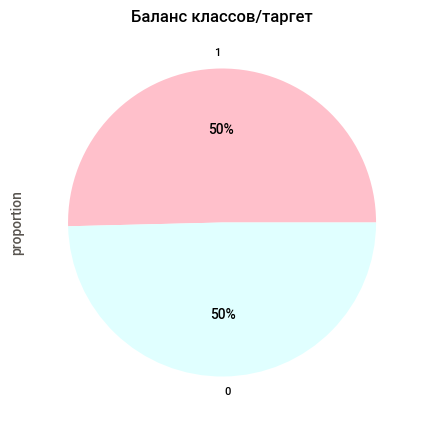

In [89]:
(fault_class.plot(y='at_fault', kind='pie', figsize=(5,5), autopct='%1.0f%%',
                 colors = ['pink', 'lightcyan'], title = 'Баланс классов/таргет')
);

### Шаг 4.6. Корреляционный анализ

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56160 entries, 0 to 56159
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              56160 non-null  int64  
 1   insurance_premium     56160 non-null  float64
 2   cellphone_in_use      56160 non-null  float64
 3   vehicle_type          56160 non-null  object 
 4   vehicle_transmission  56160 non-null  object 
 5   vehicle_age           56160 non-null  float64
 6   county_city_location  56160 non-null  int64  
 7   county_location       56160 non-null  object 
 8   distance              56160 non-null  float64
 9   direction             56160 non-null  object 
 10  weather_1             56160 non-null  object 
 11  location_type         56160 non-null  object 
 12  road_surface          56160 non-null  object 
 13  road_condition_1      56160 non-null  object 
 14  lighting              56160 non-null  object 
 15  control_device     

In [91]:
features = data.drop(['at_fault'], axis=1)
target = data['at_fault']

In [92]:
data_types = {'hour': 'categorical',
'distance':'interval',
'county_city_location':'interval',
'county_location':'categorical',
'direction': 'categorical',
'weather_1':'categorical',
'location_type':'categorical',
'insurance_premium':'interval',
              'road_surface':'categorical',
              'road_condition_1':'categorical',
              'lighting':'categorical',
              'vehicle_type':'categorical',
              'vehicle_transmission':'categorical',
              'vehicle_age':'categorical',
              'cellphone_in_use':'categorical',
              'month' : 'interval',
             'control_device':'categorical'}

In [93]:
interval_cols = [col for col, v in data_types.items() if v=='interval' and col in features.columns]
interval_cols

['distance', 'county_city_location', 'insurance_premium', 'month']

In [94]:
phik_overview = features.phik_matrix(interval_cols=interval_cols)

In [95]:
significance_overview = features.significance_matrix(interval_cols=interval_cols)

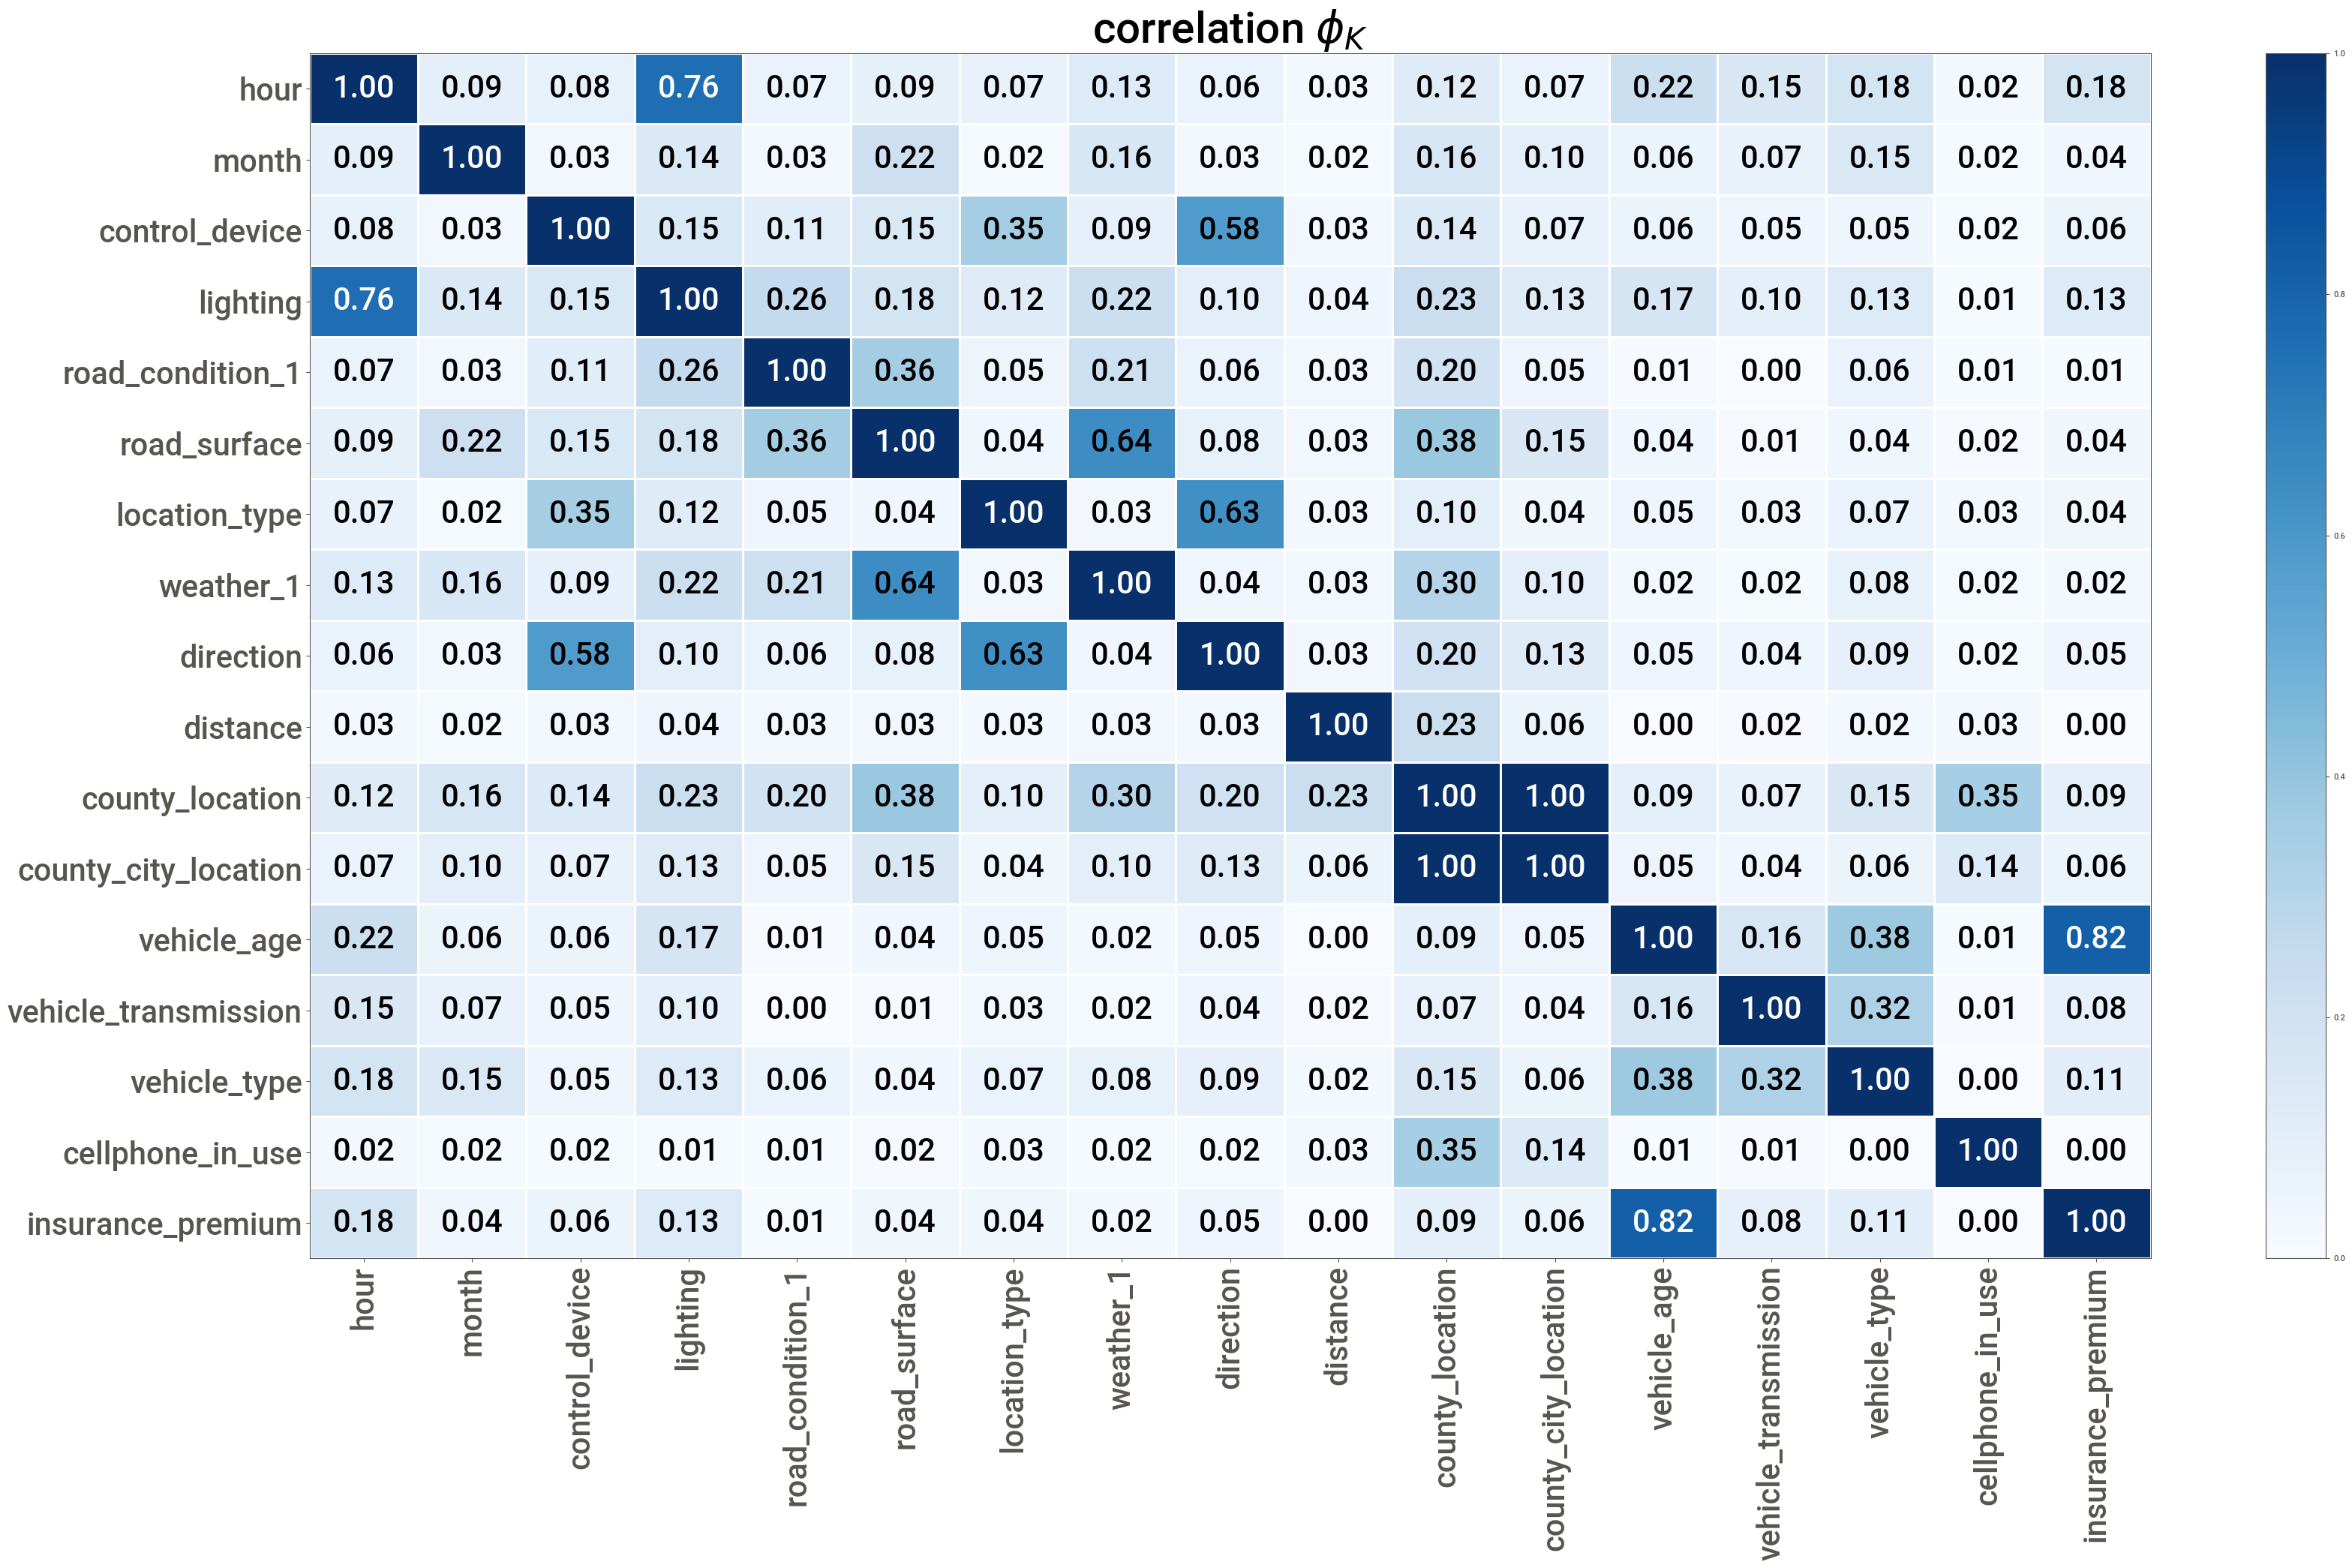

In [96]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=3,
                        figsize=(35, 21))
plt.tight_layout()

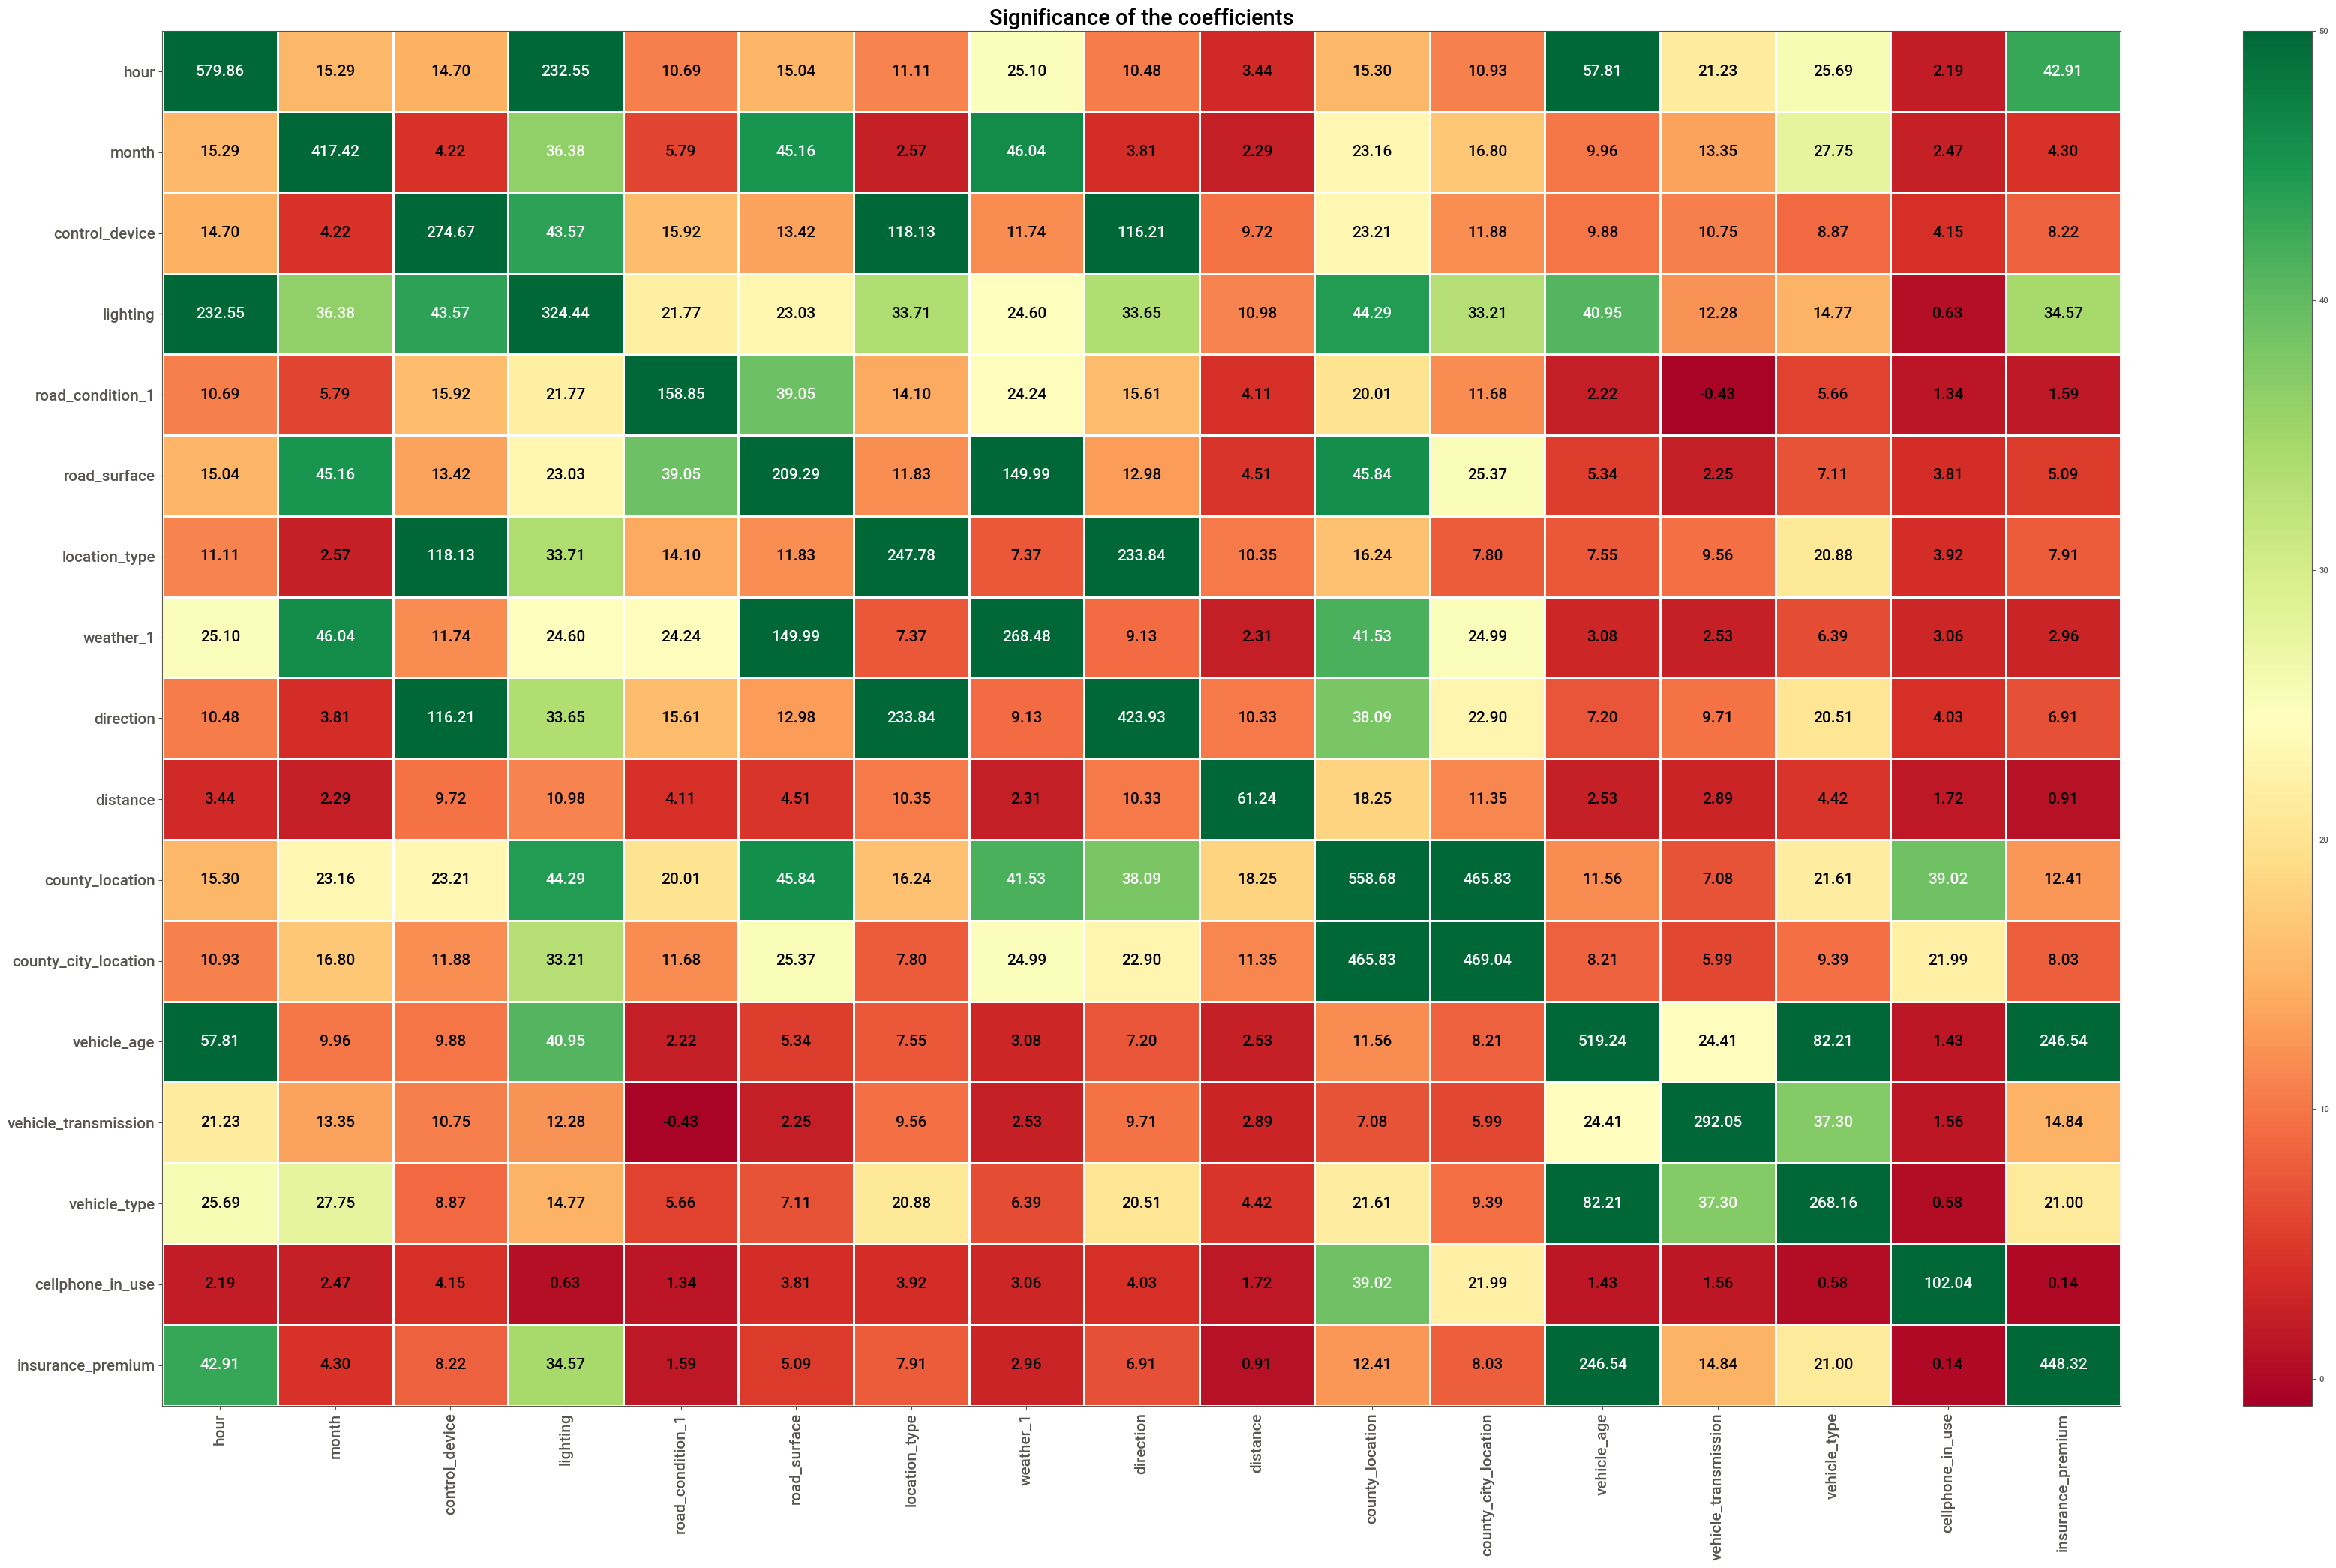

In [97]:
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-1, vmax=50, title="Significance of the coefficients",
                        usetex=False, fontsize_factor=1.5, figsize=(35, 21))
plt.tight_layout()

In [98]:
feat_corr = ['county_city_location']

In [99]:
data.drop(columns=feat_corr, inplace=True)
data.head(3)

at_fault  insurance_premium  cellphone_in_use vehicle_type  \
0         1               19.0               0.0        sedan   
1         1               22.0               0.0        coupe   
2         0               49.0               0.0        sedan   

  vehicle_transmission  vehicle_age county_location  distance  \
0               manual          3.0          fresno    1056.0   
1               manual          3.0     los angeles      20.0   
2                 auto          4.0     los angeles       0.0   

           direction weather_1 location_type road_surface road_condition_1  \
0               east     clear       highway          dry           normal   
1               east     clear       highway          dry           normal   
2  unknown_direction     clear  intersection          dry           normal   

                     lighting control_device  month hour  
0  dark with no street lights           none      1   17  
1                    daylight    functioning      1   15  
2                    daylight    functioning      1   07

В ходе корреляционного анализа и статистической значимости этих корреляций были выделены некоторые признаки - `county_city_location` (высокая корреляция с `county_location`), а также `hour`/`lighting` и  `insurance_premium`/`vehicle_age`, по условию нам требуется учитывать последний признак из этого ряда. Мы решили оставить признаки с номером часа и размером страховки.

In [100]:
data.dtypes

at_fault                  int64
insurance_premium       float64
cellphone_in_use        float64
vehicle_type             object
vehicle_transmission     object
vehicle_age             float64
county_location          object
distance                float64
direction                object
weather_1                object
location_type            object
road_surface             object
road_condition_1         object
lighting                 object
control_device           object
month                     int32
hour                     object
dtype: object

In [101]:
data['vehicle_age'] = data['vehicle_age'].astype('float32')
data['cellphone_in_use'] = data['cellphone_in_use'].astype('float32')
data['hour'] = data['hour'].astype('int32')

### Шаг 4.7. Создание трейна, валидационной выборки и тестовой выборки.

In [102]:
data_rf_dt = data.copy()

In [103]:
data_train, data_test = train_test_split(data_rf_dt, test_size=0.2, random_state=12345)

In [104]:
features_train = data_train.drop(['at_fault'], axis=1)
target_train = data_train['at_fault']

In [105]:
features_test = data_test.drop(['at_fault'], axis=1)
target_test = data_test['at_fault']

In [106]:
features_train.shape

(44928, 16)

In [107]:
target_train.shape

(44928,)

In [108]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44928 entries, 26422 to 20962
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   insurance_premium     44928 non-null  float64
 1   cellphone_in_use      44928 non-null  float32
 2   vehicle_type          44928 non-null  object 
 3   vehicle_transmission  44928 non-null  object 
 4   vehicle_age           44928 non-null  float32
 5   county_location       44928 non-null  object 
 6   distance              44928 non-null  float64
 7   direction             44928 non-null  object 
 8   weather_1             44928 non-null  object 
 9   location_type         44928 non-null  object 
 10  road_surface          44928 non-null  object 
 11  road_condition_1      44928 non-null  object 
 12  lighting              44928 non-null  object 
 13  control_device        44928 non-null  object 
 14  month                 44928 non-null  int32  
 15  hour                

# Шаг 5. Поиск лучшей модели

## Шаг 5.1 / 5.2 / 5.3 Моделирование 3-х моделей с перебором гиперпараметров.

In [109]:
ohe_features = ['county_location', 'direction', 'weather_1', 'location_type',
               'road_surface','road_condition_1', 'lighting', 'vehicle_type', 'vehicle_transmission', 'control_device']

numeric = ['distance', 'month', 'vehicle_age', 'cellphone_in_use',
                'insurance_premium', 'hour']

**LogisticRegression**

In [110]:
col_transformer_4 = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore'),
        ohe_features
),
    (
        StandardScaler(),
        numeric
    ),

    remainder = 'passthrough'
)


In [147]:
def objective2(trial):


    lr_c = trial.suggest_float('C', 1e-5, 0.2, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1, log=False)
    solver = trial.suggest_categorical('solver', ['saga'])
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    classifier_obj1 = sklearn.linear_model.LogisticRegression(C=lr_c, solver=solver, penalty=penalty,
                                                                  random_state=RANDOM_STATE,max_iter=1000,
                                                                 l1_ratio=l1_ratio)




    clf_pipeline2 = Pipeline(steps = [('ohe', col_transformer_4),
                                   ('model', classifier_obj1)],
                                    verbose = True
                           )

    with open("model_lr_best.pickle".format(trial.number), "wb") as fout:
        pickle.dump(clf_pipeline2, fout)

    return cross_val_score(clf_pipeline2, features_train, target_train, cv=5,  n_jobs=-1, scoring='f1').mean()

study2 = optuna.create_study(direction="maximize")

study2.optimize(objective2, n_trials=10)

print(study2.best_trial)

[I 2024-08-15 10:34:34,088] A new study created in memory with name: no-name-a557b6c8-a4e9-4d56-886b-88da28f207df
[I 2024-08-15 10:34:51,089] Trial 0 finished with value: 0.6023954517862155 and parameters: {'C': 0.010381209454069347, 'l1_ratio': 0.3241593391935431, 'solver': 'saga', 'penalty': 'elasticnet'}. Best is trial 0 with value: 0.6023954517862155.
[I 2024-08-15 10:35:45,215] Trial 1 finished with value: 0.6017955170874005 and parameters: {'C': 0.0451186600214964, 'l1_ratio': 0.05713759167893728, 'solver': 'saga', 'penalty': 'elasticnet'}. Best is trial 0 with value: 0.6023954517862155.
[I 2024-08-15 10:36:22,017] Trial 2 finished with value: 0.6018028185651824 and parameters: {'C': 0.034255842727924674, 'l1_ratio': 0.2220209021926377, 'solver': 'saga', 'penalty': 'elasticnet'}. Best is trial 0 with value: 0.6023954517862155.
[I 2024-08-15 10:37:32,514] Trial 3 finished with value: 0.601885657971829 and parameters: {'C': 0.07809655103018377, 'l1_ratio': 0.8086281978265819, 'solv

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[0.6702774680342914], datetime_start=datetime.datetime(2024, 8, 15, 10, 39, 39, 12934), datetime_complete=datetime.datetime(2024, 8, 15, 10, 39, 40, 578526), params={'C': 1.2804868701405611e-05, 'l1_ratio': 0.9625392777661061, 'solver': 'saga', 'penalty': 'elasticnet'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=0.2, log=True, low=1e-05, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'solver': CategoricalDistribution(choices=('saga',)), 'penalty': CategoricalDistribution(choices=('elasticnet',))}, trial_id=8, value=None)


In [148]:
study2.best_params

{'C': 1.2804868701405611e-05,
 'l1_ratio': 0.9625392777661061,
 'solver': 'saga',
 'penalty': 'elasticnet'}

In [149]:
lr_f1 = study2.best_value
lr_f1

0.6702774680342914

In [150]:
with open("model_lr_best.pickle".format(study2.best_trial.number), "rb") as fin:
    model_lr = pickle.load(fin)

**LightGBM**

In [115]:
data_lgbm_second = data.copy()

In [116]:
data_train_lgbm, data_test_lgbm = train_test_split(data_lgbm_second, test_size=0.2, random_state=12345)

In [117]:
features_train_lgbm = data_train_lgbm.drop(['at_fault'], axis=1)
target_train_lgbm = data_train_lgbm['at_fault']

In [118]:
features_test_lgbm = data_test_lgbm.drop(['at_fault'], axis=1)
target_test_lgbm = data_test_lgbm['at_fault']

In [119]:
for c in features_train_lgbm.columns:
    col_type = features_train_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_train_lgbm[c] = features_train_lgbm[c].astype('category')

In [120]:
for c in features_test_lgbm.columns:
    col_type = features_test_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        features_test_lgbm[c] = features_test_lgbm[c].astype('category')

In [121]:
dtrain = lgb.Dataset(features_train_lgbm, label=target_train_lgbm)
dtest = lgb.Dataset(features_test_lgbm, label=target_test_lgbm, reference=features_train_lgbm)

In [122]:
def objective_lgbm3(trial):

    clf = LGBMClassifier(
        num_leaves=trial.suggest_int('num_leaves', 2, 13),
        max_depth=trial.suggest_int("max_depth", 88, 90),
        n_estimators=trial.suggest_categorical("n_estimators", [199]),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.4, 1.0),
        subsample=trial.suggest_float("subsample", 0.4, 1.0),
        subsample_freq=trial.suggest_int("subsample_freq", 1, 2),
        min_child_samples=trial.suggest_int("min_child_samples", 5, 100),
        random_state=RANDOM_STATE,
    )

    with open("model_lgbm_best4.pickle".format(trial.number), "wb") as fout:
        pickle.dump(clf, fout)


    return cross_val_score(clf,features_train_lgbm, target_train_lgbm, cv=KFold(n_splits=5, shuffle=True), scoring='f1').mean()

In [123]:
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm3, n_trials=7, callbacks=[TerminatorCallback()])

print(f"The number of trials: {len(study_lgbm.trials)}")
print(f"Best value: {study_lgbm.best_value} (params: {study_lgbm.best_params})")

[I 2024-08-15 10:22:47,247] A new study created in memory with name: no-name-13df10e1-fe03-42ee-9804-2b69a88ad185
<ipython-input-123-5bf3855563aa>:2: ExperimentalWarning: TerminatorCallback is experimental (supported from v3.2.0). The interface can change in the future.
  study_lgbm.optimize(objective_lgbm3, n_trials=7, callbacks=[TerminatorCallback()])
/usr/local/lib/python3.10/dist-packages/optuna/terminator/callback.py:71: ExperimentalWarning: Terminator is experimental (supported from v3.2.0). The interface can change in the future.
  self._terminator = terminator or Terminator()
/usr/local/lib/python3.10/dist-packages/optuna/terminator/terminator.py:111: ExperimentalWarning: RegretBoundEvaluator is experimental (supported from v3.2.0). The interface can change in the future.
  self._improvement_evaluator = improvement_evaluator or RegretBoundEvaluator()
/usr/local/lib/python3.10/dist-packages/optuna/terminator/terminator.py:118: ExperimentalWarning: CrossValidationErrorEvaluator i

[LightGBM] [Info] Number of positive: 18088, number of negative: 17854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503255 -> initscore=0.013021
[LightGBM] [Info] Start training from score 0.013021
[LightGBM] [Info] Number of positive: 18145, number of negative: 17797
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [bin

[I 2024-08-15 10:22:58,676] Trial 0 finished with value: 0.6190515432262563 and parameters: {'num_leaves': 7, 'max_depth': 88, 'n_estimators': 199, 'learning_rate': 0.21285408431471842, 'reg_alpha': 0.001556612428672544, 'reg_lambda': 0.003386645503438072, 'colsample_bytree': 0.5323065314517735, 'subsample': 0.46878102905826785, 'subsample_freq': 2, 'min_child_samples': 76}. Best is trial 0 with value: 0.6190515432262563.


[LightGBM] [Info] Number of positive: 18162, number of negative: 17780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505314 -> initscore=0.021257
[LightGBM] [Info] Start training from score 0.021257
[LightGBM] [Info] Number of positive: 18034, number of negative: 17908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501753 -> initscore=0.007011
[LightG

[I 2024-08-15 10:23:03,507] Trial 1 finished with value: 0.6226637713875347 and parameters: {'num_leaves': 2, 'max_depth': 90, 'n_estimators': 199, 'learning_rate': 0.24024158456325798, 'reg_alpha': 1.1337587010719879e-05, 'reg_lambda': 4.6716413126950135e-05, 'colsample_bytree': 0.7132661893356649, 'subsample': 0.6562414647221559, 'subsample_freq': 1, 'min_child_samples': 33}. Best is trial 1 with value: 0.6226637713875347.


[LightGBM] [Info] Number of positive: 18122, number of negative: 17820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504201 -> initscore=0.016805
[LightGBM] [Info] Start training from score 0.016805
[LightGBM] [Info] Number of positive: 18071, number of negative: 17871
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [bin

[I 2024-08-15 10:23:08,004] Trial 2 finished with value: 0.6156823294003649 and parameters: {'num_leaves': 10, 'max_depth': 88, 'n_estimators': 199, 'learning_rate': 0.2918264093994891, 'reg_alpha': 8.342406070599099e-08, 'reg_lambda': 7.363596757527613, 'colsample_bytree': 0.7647960701595302, 'subsample': 0.8135042046129356, 'subsample_freq': 1, 'min_child_samples': 47}. Best is trial 1 with value: 0.6226637713875347.


[LightGBM] [Info] Number of positive: 18110, number of negative: 17832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503867 -> initscore=0.015470
[LightGBM] [Info] Start training from score 0.015470
[LightGBM] [Info] Number of positive: 18149, number of negative: 17793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [bin

[I 2024-08-15 10:23:14,025] Trial 3 finished with value: 0.6206659719785431 and parameters: {'num_leaves': 9, 'max_depth': 90, 'n_estimators': 199, 'learning_rate': 0.1834243169572685, 'reg_alpha': 3.4319554376943725e-07, 'reg_lambda': 0.2758569647451315, 'colsample_bytree': 0.5501022439716614, 'subsample': 0.6666917046761808, 'subsample_freq': 1, 'min_child_samples': 6}. Best is trial 1 with value: 0.6226637713875347.


[LightGBM] [Info] Number of positive: 18179, number of negative: 17763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505787 -> initscore=0.023149
[LightGBM] [Info] Start training from score 0.023149
[LightGBM] [Info] Number of positive: 18112, number of negative: 17830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [bin

[I 2024-08-15 10:23:19,417] Trial 4 finished with value: 0.6196877621281524 and parameters: {'num_leaves': 8, 'max_depth': 88, 'n_estimators': 199, 'learning_rate': 0.21072349132196613, 'reg_alpha': 5.660924054431377e-07, 'reg_lambda': 4.8130803070301686e-08, 'colsample_bytree': 0.8918181932746185, 'subsample': 0.9185621372814928, 'subsample_freq': 1, 'min_child_samples': 47}. Best is trial 1 with value: 0.6226637713875347.


[LightGBM] [Info] Number of positive: 18176, number of negative: 17766
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505704 -> initscore=0.022816
[LightGBM] [Info] Start training from score 0.022816
[LightGBM] [Info] Number of positive: 18188, number of negative: 17754
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [bin

[I 2024-08-15 10:23:24,907] Trial 5 finished with value: 0.6219609330309932 and parameters: {'num_leaves': 11, 'max_depth': 89, 'n_estimators': 199, 'learning_rate': 0.12433468740271357, 'reg_alpha': 4.9682624178365945e-05, 'reg_lambda': 8.103540113277382e-07, 'colsample_bytree': 0.5984485842245768, 'subsample': 0.731524495657759, 'subsample_freq': 1, 'min_child_samples': 83}. Best is trial 1 with value: 0.6226637713875347.


[LightGBM] [Info] Number of positive: 18109, number of negative: 17833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503840 -> initscore=0.015358
[LightGBM] [Info] Start training from score 0.015358
[LightGBM] [Info] Number of positive: 18142, number of negative: 17800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 35942, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] 

[I 2024-08-15 10:23:30,687] Trial 6 finished with value: 0.621886084516961 and parameters: {'num_leaves': 10, 'max_depth': 88, 'n_estimators': 199, 'learning_rate': 0.14149821502058663, 'reg_alpha': 2.2759744057367985e-05, 'reg_lambda': 0.0011201944685981092, 'colsample_bytree': 0.6877829946847094, 'subsample': 0.6206010956496475, 'subsample_freq': 1, 'min_child_samples': 60}. Best is trial 1 with value: 0.6226637713875347.


The number of trials: 7
Best value: 0.6226637713875347 (params: {'num_leaves': 2, 'max_depth': 90, 'n_estimators': 199, 'learning_rate': 0.24024158456325798, 'reg_alpha': 1.1337587010719879e-05, 'reg_lambda': 4.6716413126950135e-05, 'colsample_bytree': 0.7132661893356649, 'subsample': 0.6562414647221559, 'subsample_freq': 1, 'min_child_samples': 33})


In [124]:
study_lgbm.best_params

{'num_leaves': 2,
 'max_depth': 90,
 'n_estimators': 199,
 'learning_rate': 0.24024158456325798,
 'reg_alpha': 1.1337587010719879e-05,
 'reg_lambda': 4.6716413126950135e-05,
 'colsample_bytree': 0.7132661893356649,
 'subsample': 0.6562414647221559,
 'subsample_freq': 1,
 'min_child_samples': 33}

In [125]:
lgbm_f1 = study_lgbm.best_value
lgbm_f1

0.6226637713875347

**CatBoostClassifier**

In [126]:
data_catboost = data.copy()

In [127]:
data_tr_cat, data_tst_cat = train_test_split(data_catboost, test_size=0.2, random_state=12345)

In [128]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=123456)

In [129]:
oe.fit(data_tr_cat)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=123456)

In [130]:
data_train1 = (pd.DataFrame(oe.transform(data_tr_cat),
                                   columns=data_tr_cat.columns)
)

In [131]:
data_test1 = (pd.DataFrame(oe.transform(data_tst_cat),
                                   columns=data_tst_cat.columns)
)

In [132]:
features_cat_train = data_train1.drop(['at_fault'], axis=1)
target_cat_train = data_train1['at_fault']

In [133]:
features_cat_test = data_test1.drop(['at_fault'], axis=1)
target_cat_test = data_test1['at_fault']

In [134]:
train_pool = Pool(features_cat_train, label=target_cat_train)
test_pool = Pool(features_cat_test, label=target_cat_test)

In [135]:
def objective_catboost(trial):

    cv_outer=KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 15, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "eval_metric": "F1",
        "n_estimators": trial.suggest_int("n_estimators", 343, 344),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 2.5, 4),
        "learning_rate": trial.suggest_float("eta", 1e-2, 1e-1, log=True),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 5),
        'silent':trial.suggest_categorical('silent',[True]),
        'random_state': trial.suggest_categorical('random_state', [RANDOM_STATE])
            }


    gbm = CatBoostClassifier(**param)



    return cross_val_score(gbm, features_cat_train, target_cat_train,cv=cv_outer,scoring='f1').mean()

In [136]:
study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(objective_catboost, n_trials=10)


print(f"The number of trials: {len(study_catboost.trials)}")
print(f"Best value: {study_catboost.best_value} (params: {study_catboost.best_params})")

[I 2024-08-15 10:23:31,297] A new study created in memory with name: no-name-e32f2099-2ca0-4b6c-92b8-793fc2329634
[I 2024-08-15 10:24:26,805] Trial 0 finished with value: 0.6212048621810338 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.047665794198806045, 'depth': 16, 'boosting_type': 'Ordered', 'n_estimators': 344, 'l2_leaf_reg': 3.376097275831629, 'eta': 0.03274858167710437, 'min_data_in_leaf': 5, 'silent': True, 'random_state': 12345}. Best is trial 0 with value: 0.6212048621810338.
[I 2024-08-15 10:25:19,753] Trial 1 finished with value: 0.6116391979754063 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.030160987464214188, 'depth': 16, 'boosting_type': 'Ordered', 'n_estimators': 344, 'l2_leaf_reg': 3.797767816946093, 'eta': 0.03765014035909968, 'min_data_in_leaf': 2, 'silent': True, 'random_state': 12345}. Best is trial 0 with value: 0.6212048621810338.
[I 2024-08-15 10:25:32,027] Trial 2 finished with value: 0.6191332197454064 and parameters:

The number of trials: 10
Best value: 0.6261202022414885 (params: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.021805175097315513, 'depth': 16, 'boosting_type': 'Ordered', 'n_estimators': 344, 'l2_leaf_reg': 3.7848115503149806, 'eta': 0.012999104284837906, 'min_data_in_leaf': 1, 'silent': True, 'random_state': 12345})


In [137]:
catboost_f1 = study_catboost.best_value
catboost_f1

0.6261202022414885

## Шаг 5.4. Выбор метрики для оценки модели, исходя из поставленной бизнесом задачи. Обоснование своего выбора.

**Мы выбрали метрику - F1-мера.** Наш выбор обусловлен поставленной бизнесом задачей : **"разработать модель, которая могла бы оценить вероятность ДТП с любым повреждением транспортного средства".**

Так как происходит оценка рисков ДТП, то метрика accuracy нам не подходит (хотя у нас сохранен относительный баланс классов), ведь цена ошибки высока - поэтому мы выбираем среднее гармоническое между точностью (precision) и полнотой (recall) - метрику F1-меры (F1-measure). Существует вероятность предсказания ложноотрицательных результатов — и это действительно несет за собой риски (например, предсказание того, что маршрут безопасен, когда он таковым не является), поэтому F1-measure будет более релевантной оценкой в этом случае, нежели если ориентироваться на другие метрики.

## Шаг 5.5. Вывод в виде сравнительной таблицы.

In [159]:
model2 = [ ('LogisticRegression', lr_f1),
         ('LightGBM', lgbm_f1), ('CatBoost', catboost_f1)]

table = pd.DataFrame(model2)
table.columns = ['model', 'f1_score']
table.sort_values('f1_score', ascending=False)

model  f1_score
0  LogisticRegression  0.670277
2            CatBoost  0.626120
1            LightGBM  0.622664

# Шаг 6. Тестирование:

**LogisticRegression**

In [151]:
print(model_lr)

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['county_location',
                                                   'direction', 'weather_1',
                                                   'location_type',
                                                   'road_surface',
                                                   'road_condition_1',
                                                   'lighting', 'vehicle_type',
                                                   'vehicle_transmission',
                                                   'control_device']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                             

In [152]:
model_lr.fit(features_train, target_train)

[Pipeline] ............... (step 1 of 2) Processing ohe, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.2s


Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['county_location',
                                                   'direction', 'weather_1',
                                                   'location_type',
                                                   'road_surface',
                                                   'road_condition_1',
                                                   'lighting', 'vehicle_type',
                                                   'vehicle_transmission',
                                                   'control_device']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['distance', 'month',
                                                   'vehicle_age',
                                                   'cellphone_in_use',
                                                   'insurance_premium',
                                                   'hour'])])),
                ('model',
                 LogisticRegression(C=0.00012907575646608645,
                                    l1_ratio=0.7504650869247019, max_iter=1000,
                                    penalty='elasticnet', random_state=12345,
                                    solver='saga'))],
         verbose=True)

In [153]:
lr_pred = model_lr.predict(features_test)

In [154]:
lr_f1_test = f1_score(target_test, lr_pred)
lr_f1_test

0.6695095948827292

**На тесте:**


**F1 = 0.6695095948827292 LogisticRegression**




## Шаг 6.1. Графический анализ «Матрица ошибок».

In [155]:
cm = confusion_matrix(target_test, lr_pred, labels=model_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_lr.classes_)

In [156]:
cm

array([[   0, 5580],
       [   0, 5652]])

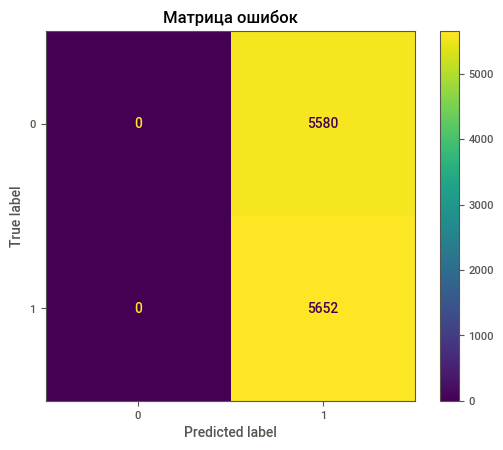

In [157]:
disp.plot()
plt.title('Матрица ошибок')
plt.show()

Мы правильно предсказали положительную метку **5652** раз и угадали - это **true positive (TP).**

Мы предсказали положительную метку, но ошиблись в своём предсказании **5580** раз – это **false positive (FP).**

**0** раз мы предсказали отрицательную метку и угадали – это **true negative (TN).**

Мы предсказали **0** раз отрицательную метку, но ошиблись – это **false negative (FN).**



# Шаг 7. Общий вывод по модели

Лучшая модель - **LogisticRegression**

Best value:  

F1 = **0.6702774680342914** (на **трейне**)


F1 = **0.6695095948827292** (на **тесте**)


Параметры:  {
               
     'C': 1.2804868701405611e-05,
       'l1_ratio': 0.9625392777661061,
         'solver': 'saga',
          'penalty': 'elasticnet'

 }

# Шаг 8. Выводы

Процесс подготовки проекта был разделен на несколько частей:

1) Загрузка таблиц SQL;

2) Исследование таблиц, проведен статистический анализ факторов ДТП;

3) Подготовка данных и их предобработка, замена аномальных значений, проведено исследование баланса классов, проведен корреляционный анализ, созданы обучающая, валидационная и тестовая выборки;

4) Выбор метрики;

5) Смоделировано 3 модели, среди них: LogisticRegression, LightGBMClassifier, CatBoostClassifier;


**Результаты модели на тренировочной выборке:**

In [158]:
table.sort_values('f1_score', ascending=False)

model  f1_score
0  LogisticRegression  0.670277
2            CatBoost  0.626120
1            LightGBM  0.622664

6) Проведен графический анализ "Матрица ошибок".


Итог:

Лучшая модель - **LogisticRegression**


F1 = **0.6695095948827292** (на **тесте**)


**Параметры:**


    'C': 1.2804868701405611e-05,

    'l1_ratio': 0.9625392777661061,

    'solver': 'saga',

    'penalty': 'elasticnet'
